# Malware classification, a simple comparison:
## dynamic analysis features, text vectorizers, metrics and winning models

# intro

## TL;DR
This notebook takes cuckoo-sandbox reports and process them into long sentences builded from system-calls ('syscalls'). 

It then labels them according to VirusTotal ('VT') AVs results.

Then, we build features from the sentences using Frequency of Ngrams (we're using frequency method for simplicity reasons, we coul'd have used TF-IDF just as well).

We train different models on these features and compare simple metrics and curves, and lastly announcing winning classifiers. 


## אמ;לק
מחברת שמעבדת דוחות קוקו, והופכת אותם למשפטים ארוכים של סיסקולים עם לייבל מתאים מוירוס-טוטאל

לאחר מכן בונים מהמשפטים פיצ'רים באמצעות תדירות הופעה של אן-גרמים (באותה מידה אפשר גם לבצע -טי-אף-איי-די-אף)

ומריצים מודלים קלאסיים ואחרים (לוגיסטיק-רגרשן / רנדום-פורסט)

לבסוף אנחנו משווים מטריקות וגרפים ומכריזים על מסווגים מנצחים


## Dataset

We're using a fraction from The Berkeley Detection Platform, a malware-dataset containing over 1 million samples collected over a period of 2.5 years.

http://secml.cs.berkeley.edu/detection_platform/


### project imports

In [1]:
#### project imports

# basis
import os
import json
import sys
import itertools
from pathlib import Path
import pandas
import numpy

# feature_extraction
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# models
from sklearn import linear_model
from sklearn import  ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# metrics and curves
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# nir added for sort-by-timestamp
from datetime import datetime


### setting pathes for data directory 

In [2]:
# TODO: set data dir 
#cuckoo_reports_dir_Path = Path("/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/")
#labels_dict_Path = Path("/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/labels.json")
cuckoo_reports_dir_Path = Path("/mnt/nvme_write/Code/miller/miller60K_balanced_1K_mal7_mse1K/")
labels_dict_Path = Path("/mnt/nvme_write/Code/miller/miller60K_balanced_1K_mal7_mse1K/labels_550K.json")

!file /home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/test/0009e4770ea519865c55e9e8dff5c9a537740761a14e8aac3c69bb7d47a92115

!ls -ali /mnt/nvme_write/Code/miller/miller60K_balanced_1K_mal7_mse1K/
!file /mnt/nvme_write/Code/miller/miller60K_balanced_1K_mal7_mse1K/train/0000*

/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/test/0009e4770ea519865c55e9e8dff5c9a537740761a14e8aac3c69bb7d47a92115: cannot open `/home/john/Desktop/SCLR/IGNORE/miller700_150_ratio05/test/0009e4770ea519865c55e9e8dff5c9a537740761a14e8aac3c69bb7d47a92115' (No such file or directory)
total 108616
548277 drwxrwxrwx 1 root root     4096 Sep 29 22:56 .
495809 drwxrwxrwx 1 root root   786432 Oct 10 13:09 ..
548281 drwxrwxrwx 1 root root        0 Sep 29 19:21 flatten
608456 -rwxrwxrwx 1 root root 65104656 Sep 26 20:30 labels_550K.json
608468 drwxrwxrwx 1 root root 19709952 Sep 29 22:01 new_tensors_Max1000
608474 -rwxrwxrwx 1 root root      882 Sep 29 21:15 syscall_mapping1_fix_Max1000.pickle
548280 drwxrwxrwx 1 root root  2965504 Sep 29 20:25 test
548284 -rwxrwxrwx 1 root root   834469 Sep 29 19:23 test_balanced_order.csv
548278 drwxrwxrwx 1 root root 14086144 Sep 29 20:08 train
548282 -rwxrwxrwx 1 root root  3925862 Sep 29 19:23 train_balanced_order.csv
548279 drwxrwxrwx 1 root root  2

## load syscalls data 

### for each cuckoo report, sort syscalls (from all processes) by timestamps, and create a sentece from the first 'max_seq_len'.

In [3]:
max_seq_len = 1000 # 500  # lowest limit = 500
i=0
labels = {}
processed_sequences = {}

with open(labels_dict_Path, 'rb') as labels_dict_handle:
    labels_dict = json.load(labels_dict_handle)

    
for set in ["train", "test"]:
    labels[set] = []
    processed_sequences[set] = []
    for report_file in os.listdir(cuckoo_reports_dir_Path/set):
        i=i+1
        with open(file=cuckoo_reports_dir_Path/set/report_file, mode='r', encoding="latin-1") as report_file_handle: # deleted 'rb'
            try:
                report_data = json.load(report_file_handle)

                # extract sorted calls by time:
                calls_times_dict = {}
                procs_list = report_data['behavior']['processes']
                extracted_procs_dict_list = []
                for proc_dict in procs_list:
                    calls_list = proc_dict["calls"]
                    extracted_proc_dict_list = []
                    for call_dict in itertools.islice(calls_list, 0, max_seq_len):
                        timestamp_str = call_dict['timestamp']
                        date_time_obj = datetime.strptime(timestamp_str, '%Y%m%d%H%M%S.%f')
                        syscall_str = call_dict['api']
                        extracted_calls_times_dict = {}
                        extracted_calls_times_dict['date_time_obj'] = date_time_obj
                        extracted_calls_times_dict['syscall_str'] = syscall_str
                        extracted_proc_dict_list.append(extracted_calls_times_dict)
                    extracted_procs_dict_list.extend(extracted_proc_dict_list)
                extracted_procs_dict_list = sorted(extracted_procs_dict_list,
                                                       key=lambda call: call['date_time_obj'],
                                                       reverse=False)[0:max_seq_len]
                seq_sentence = ' '.join(d['syscall_str'] for d in extracted_procs_dict_list)
                processed_sequences[set].append(seq_sentence)

                # extract label for this sample (only if no excep occured):
                sha256 = report_file  # report_data['sha256']
                score = numpy.float64(labels_dict[sha256]['score'])
                syscalls_label = 1 if score > 5 else 0
                labels[set].append(syscalls_label)

            except json.JSONDecodeError as err:
                print("process report {0}   JSONDecodeError error: {1}".format(report_file, err))
                pass
            except:
                print("process_reports_file: {0}, error: {1}".format(report_file, sys.exc_info()))
                pass


process_reports_file: 85f683e7929a2063e1368a584c3c45962581b7b2327d3649e4956990a918b7f6, error: (<class 'ValueError'>, ValueError('unconverted data remains: "'), <traceback object at 0x7f5b5616fb90>)
process_reports_file: 2d5e666325818bca30c3ecd02e9a93d67f0297c2a50324b9c667c2b813d498a1, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b55a29960>)
process_reports_file: b1a31bb2bea219bd87b3590b1ece7b9133da2c35ca66b9513bf35ce24e380555, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b56db9b90>)
process_reports_file: 4fb20f2cb1b6d7e21eb6e3b20244046999e6b06269a9d685579f0ec89db3e952, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5649e410>)
process_reports_file: 7ecdfebe86e724ad46fca68324f11505cf8fc1e25668dbd99941b26e186fcf0e, error: (<class 'ValueError'>, ValueError('unconverted data remains: "'), <traceback object at 0x7f5b55b642d0>)
process_reports_file: 502ef8f3c9ed54cd5e7379370ce944108e246ed6c392e077060a

process_reports_file: de8583c36ffb3eda5362bf83d4c321b8542f35f7f101ef70656518d6d7bcbf5e, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b54626960>)
process_reports_file: 59fba8ce34f3ae561a9b88121d57db669a2568f0e8206bd54d51657e6b07b269, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b57036d70>)
process_reports_file: 5a04a5d5fae0ac68b392f16ba1d28f1710975f7bb30d31c75b2fc8bd5fafb8cf, error: (<class 'ValueError'>, ValueError('time data \'exe"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f5b57748280>)
process_reports_file: d72033927d8b98c4999899e285a38690b294c76a043cfb292eec770635573909, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b557a6820>)
process_reports_file: 18e500f78a0bbf907557e7f25fc3cea99d9ae2ec7627306f2879109ffa6280aa, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b54a999b0>)
process_reports_file: be97f2b5e1d2f828b7d244215d20b2891b74c51077

process_reports_file: b727e836140c2db40e3baecfe37ff7b67c5d69ed46edfb6dda01a7564433a001, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5671ce10>)
process_reports_file: 7bd5a4b65661f890a2e6a597be37e81151c658e5a933349afe7e1db4c5760bba, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5445caf0>)
process_reports_file: 6d94bb554706cd1595e9c4e776751173ab831f345dfffaa281c9fb90f09447b0, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5b4bbfa0>)
process_reports_file: a569cd79e52cd53b633786956db1faff7ceaa1793127b8d146a7678357ad103e, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5b4d5d70>)
process_reports_file: 13e6fb58f3125e8d8bf22b6bdd98705e5ec7e9aed49b2285a13849e2180cd1bc, error: (<class 'ValueError'>, ValueError('time data \'40229.834"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f5b5b5345f0>)
process_reports_file: 032dffad0ad1893362d2bb085c5760718c3e

process_reports_file: aae01e5c361f27e5fb8be7340671ce6e3340a99fee1e3107e208326d64ea4d86, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b56078e60>)
process_reports_file: 2788f56d1a9ca47e8d06f7c9f703cb780a238381992c4b390c2f1058ca47c7fa, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b567acaa0>)
process_reports_file: 9d4c133dd22dd0595ded5819367119ae2c764ce9f2575438b43a6536fecf05a9, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b52b66730>)
process_reports_file: bb6f1e5766efc37a8d18f88acb24c615b5733544e3a196650c38b7f03e978e85, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b85818d70>)
process_reports_file: c5a160110d153125fcceeaea7053fd3ca0c3bef02c62a4eca7dc2e66bb3d949e, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5622c460>)
process_reports_file: f79493867ee4a49ceb9a2ec8e02a82ed09c12e6f0afd8f40d4f17253eafbbf0d, error: (<class 'ValueError'>, Va

process_reports_file: 36bb0447697ba29d74fd3a0b687435e7307c52eeea93864a38ed5adc2961468f, error: (<class 'ValueError'>, ValueError('time data \'1536"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f5b54c8c870>)
process_reports_file: a06665f8b00ef2b2c26a9f9952defe485ebe0918581ce670eedc38fbf2c0153a, error: (<class 'ValueError'>, ValueError('time data \'536"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f5b55416cd0>)
process_reports_file: 293a35be928cd3e18f73b36cda434b3276fce42e682262d61b210786f5a36820, error: (<class 'KeyError'>, KeyError('behavior'), <traceback object at 0x7f5b5758e8c0>)
process_reports_file: 72c7385344d1f9b37d6d7403887ca89ae094a503fede23ea66e25543a72dd180, error: (<class 'ValueError'>, ValueError('time data \'2.183"\' does not match format \'%Y%m%d%H%M%S.%f\''), <traceback object at 0x7f5b577485f0>)
process_reports_file: 9bdfe4a05367cdeaf87a46418213ea3310b70cca10a372ff4ffc3cb3f25a741a, error: (<class 'ValueError'>, ValueEr

In [4]:
processed_sequences["train"][0][0:100]

'DeviceIoControl LoadLibraryA VirtualAllocEx VirtualAllocEx VirtualAllocEx VirtualAllocEx VirtualAllo'

In [5]:
len(processed_sequences["train"])

41850

In [6]:
len(processed_sequences["test"])

8966

#### convert data to pandas.DataFrame

In [7]:
trainDF = pandas.DataFrame()
trainDF['text'] = processed_sequences["train"]
trainDF['label'] = labels["train"]
train_x, train_y = trainDF['text'], trainDF['label']

testDF = pandas.DataFrame()
testDF['text'] = processed_sequences["test"]
testDF['label'] = labels["test"]
test_x, test_y = testDF['text'], testDF['label']

# counting #differents syscalls in the data

In [8]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))
cv_fit = count_vect.fit_transform(train_x)
print(count_vect.get_feature_names()[0:10])
print(len(count_vect.get_feature_names()))

['controlservice', 'copyfileexw', 'createfilew', 'createmutexw', 'createprocessinternalw', 'createremotethread', 'createservicea', 'createservicew', 'deletefilew', 'deleteservice']
46


In [9]:
itidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))
itidf_fit = itidf_vect.fit_transform(train_x)
print(itidf_vect.get_feature_names()[0:10])
print(len(itidf_vect.get_feature_names()))

['controlservice', 'copyfileexw', 'createfilew', 'createmutexw', 'createprocessinternalw', 'createremotethread', 'createservicea', 'createservicew', 'deletefilew', 'deleteservice']
46


## build model and features with sklearn 


#### declare func: Train model, calc metrics and build ROC and P@R curves on Test set

In [10]:
def train_test_model(model, model_name, trainX, trainy, testX, testy, is_neural_net=False):
    
    # fit the training dataset on the classifier
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_PR_f1, lr_PR_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    
    # nir added metricsPR-
    acc = accuracy_score(testy, yhat)
    precision, recall, ROC_auc = precision_score(testy, yhat), recall_score(testy, yhat), roc_auc_score(testy, lr_probs)
    # summarize scores
    print('\t Model: precision=%.3f recall=%.3f ROC-auc=%.3f accuracy=%.3f P@R-f1=%.3f P@R-auc=%.3f' % (precision, recall, ROC_auc, acc, lr_PR_f1, lr_PR_auc))
    
    # create 2 plots:
    _, axes = plt.subplots(1, 2, figsize=(20, 5))
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    axes[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    axes[0].plot(lr_recall, lr_precision, marker='.', label='Model')
    # set title
    axes[0].set_title('Precision@Recall-Curve ('+model_name+')')
    # axis labels
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    # show the legend
    axes[0].legend()    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('\t No Skill: ROC AUC=%.3f' % (ns_auc))
    print('\t Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    axes[1].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    axes[1].plot(lr_fpr, lr_tpr, marker='.', label='Model')
    # set title
    axes[1].set_title('ROC-curve ('+model_name+')')
    # axis labels
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    # show the legend
    axes[1].legend()

    ret = {}
    ret['model'] = model_name
    ret['precision'] = precision
    ret['recall'] = recall
    ret['ROC_auc'] = ROC_auc
    ret['acc'] = acc
    ret['lr_PR_f1'] = lr_PR_f1
    ret['lr_PR_auc'] = lr_PR_auc
    ret['ns_auc'] = ns_auc
    ret['lr_auc'] = lr_auc
    
    return ret 

## comparing the calssifiers:
### Scikit-learn built-in models with Ngram from the syscalls sequences

In [11]:
# suppressing warnings for pretty prints
import warnings
warnings.filterwarnings("ignore")

In [12]:
n = 4
ngrams_dict_list = []
for i in range(1, n+1):
    for j in range(1, i+1):
        ngram = (j,i)
        ngram_name = str(ngram)+'-Grams'
        ngrams_dict_list.append((ngram, ngram_name))

In [13]:
# there are some commented models 
# that doesn't accept "new-syscalls" 
# which didn't appeared in the train-set
models_and_names_list = [(linear_model.LogisticRegression(), "LR"), \
                         (ensemble.RandomForestClassifier(), "RF"), \
                         (KNeighborsClassifier(3), "3 Nearest Neighbors"), \
                         (DecisionTreeClassifier(max_depth=5), "Decision Tree"), \
                         (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "10 Random Forest 5-max-depth"), \
                         (MLPClassifier(alpha=1, max_iter=1000), "Neural Net"), \
                         (AdaBoostClassifier(), "AdaBoost"), \
                         #(SVC(kernel="linear", C=0.025), "Linear SVM"), \
                         #(SVC(gamma=2, C=1), "RBF SVM"), \
                         #(GaussianProcessClassifier(1.0 * RBF(1.0)), "Gaussian Process"), \
                         #(GaussianNB(), "Gaussian Naive Bayes"), \
                         #(QuadraticDiscriminantAnalysis(), "QDA")
                        ]

In [14]:
vectorizers_and_names_list = [(CountVectorizer, "CountVectorizer"), \
                              (TfidfVectorizer, "TfidfVectorizer")]

model: LR with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.714 recall=0.737 ROC-auc=0.782 accuracy=0.721 P@R-f1=0.725 P@R-auc=0.808
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.782
model: RF with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.794 recall=0.647 ROC-auc=0.849 accuracy=0.740 P@R-f1=0.713 P@R-auc=0.855
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.849
model: 3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.735 recall=0.677 ROC-auc=0.791 accuracy=0.717 P@R-f1=0.705 P@R-auc=0.813
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.791
model: Decision Tree with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.628 recall=0.610 ROC-auc=0.708 accuracy=0.625 P@R-f1=0.619 P@R-auc=0.751
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.708
model: 10 Random Forest 5-max-depth with (1, 1)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.658 recall=0.724 ROC-auc=0.744 accuracy=0.675 P@R-f1=0.689 P@R-auc=0

	 Model: precision=0.663 recall=0.634 ROC-auc=0.748 accuracy=0.656 P@R-f1=0.648 P@R-auc=0.752
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.748
model: AdaBoost with (2, 2)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.800 recall=0.691 ROC-auc=0.813 accuracy=0.760 P@R-f1=0.741 P@R-auc=0.845
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.813
model: LR with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.760 recall=0.736 ROC-auc=0.832 accuracy=0.752 P@R-f1=0.747 P@R-auc=0.863
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.832
model: RF with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.847 recall=0.674 ROC-auc=0.883 accuracy=0.776 P@R-f1=0.751 P@R-auc=0.883
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.883
model: 3 Nearest Neighbors with (1, 3)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.753 recall=0.718 ROC-auc=0.822 accuracy=0.741 P@R-f1=0.735 P@R-auc=0.843
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.822
model: Decision Tree with (1, 3)-G

	 Model: precision=0.709 recall=0.581 ROC-auc=0.753 accuracy=0.672 P@R-f1=0.639 P@R-auc=0.708
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.753
model: 10 Random Forest 5-max-depth with (3, 3)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.511 recall=0.110 ROC-auc=0.521 accuracy=0.503 P@R-f1=0.181 P@R-auc=0.501
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.521
model: Neural Net with (3, 3)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.643 recall=0.781 ROC-auc=0.778 accuracy=0.674 P@R-f1=0.705 P@R-auc=0.788
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.778
model: AdaBoost with (3, 3)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.746 recall=0.796 ROC-auc=0.869 accuracy=0.763 P@R-f1=0.770 P@R-auc=0.896
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.869
model: LR with (1, 4)-Grams-CountVectorizer-vectorizer


	 Model: precision=0.814 recall=0.733 ROC-auc=0.845 accuracy=0.783 P@R-f1=0.771 P@R-auc=0.874
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.845
model: RF with (1

	 Model: precision=0.801 recall=0.721 ROC-auc=0.851 accuracy=0.771 P@R-f1=0.759 P@R-auc=0.846
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.851
model: 3 Nearest Neighbors with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.775 recall=0.728 ROC-auc=0.804 accuracy=0.759 P@R-f1=0.751 P@R-auc=0.839
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.804
model: Decision Tree with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.846 recall=0.420 ROC-auc=0.745 accuracy=0.672 P@R-f1=0.561 P@R-auc=0.765
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.745
model: 10 Random Forest 5-max-depth with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.501 recall=0.829 ROC-auc=0.503 accuracy=0.503 P@R-f1=0.625 P@R-auc=0.644
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0.503
model: Neural Net with (3, 4)-Grams-TfidfVectorizer-vectorizer


	 Model: precision=0.645 recall=0.809 ROC-auc=0.795 accuracy=0.682 P@R-f1=0.717 P@R-auc=0.801
	 No Skill: ROC AUC=0.500
	 Model: ROC AUC=0

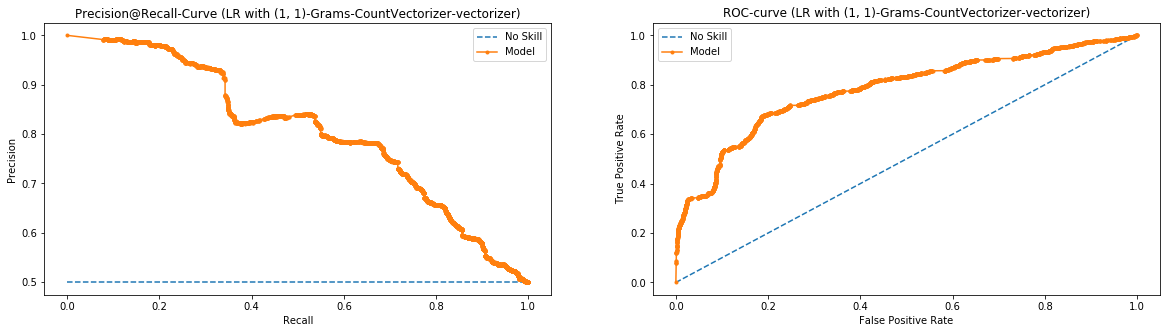

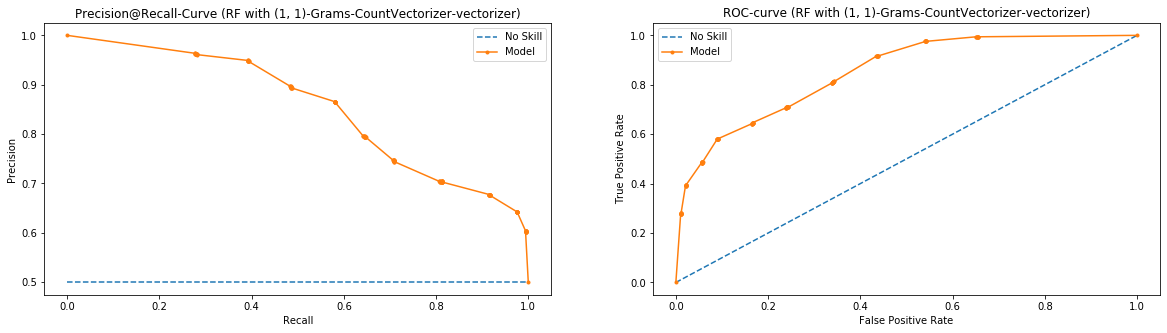

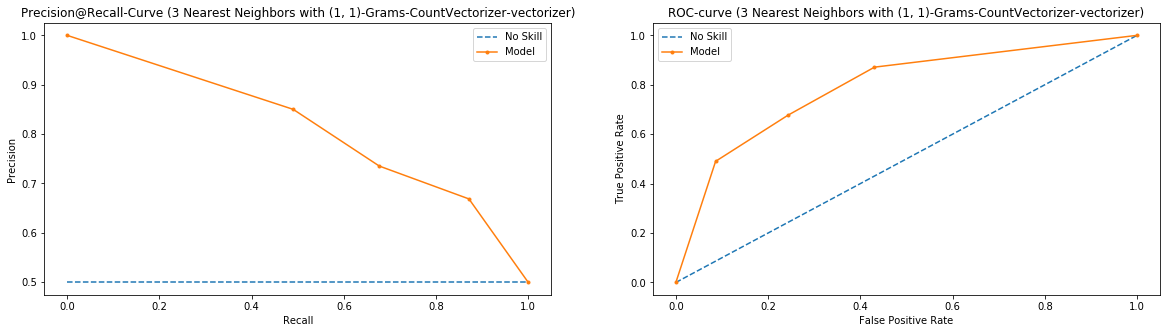

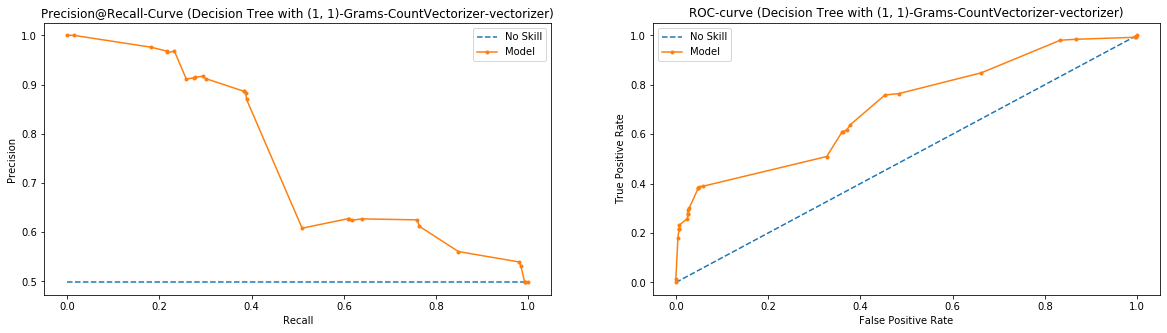

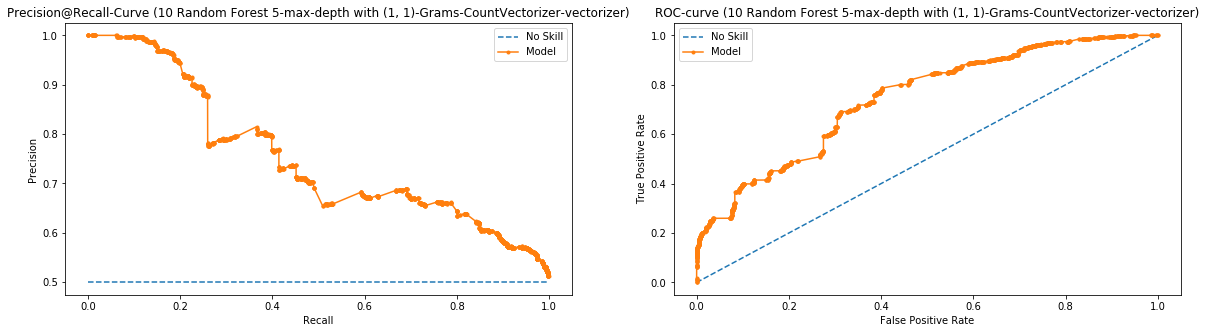

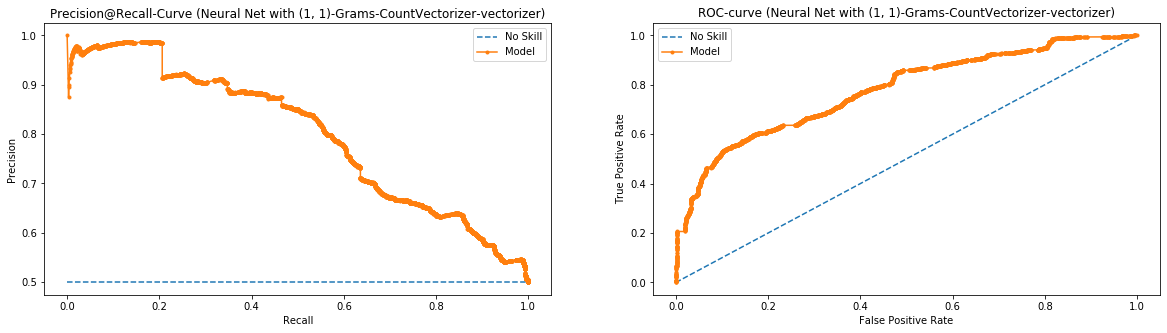

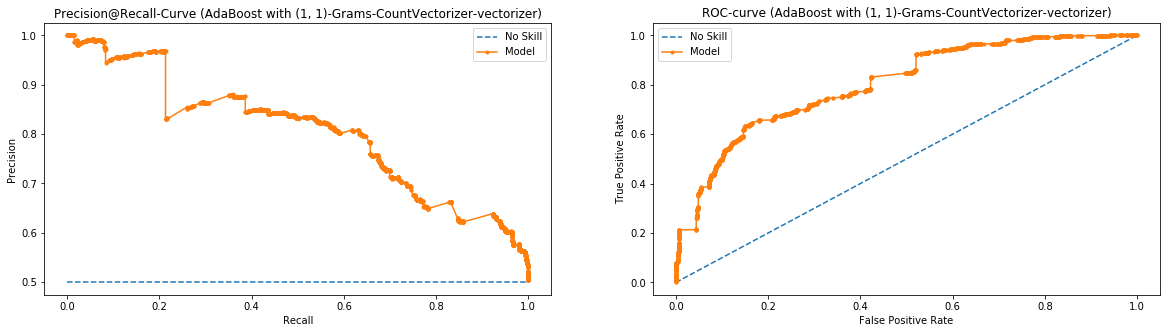

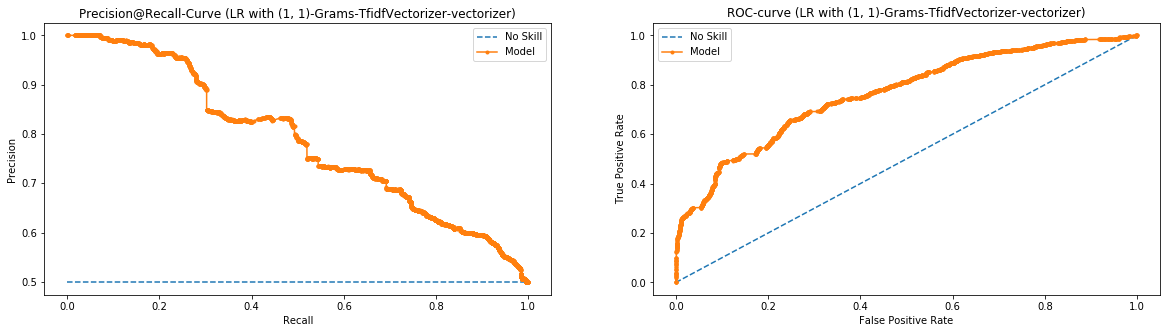

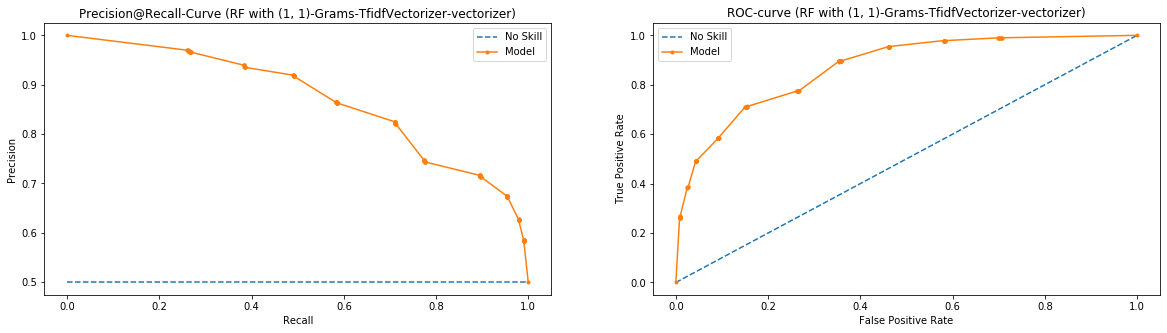

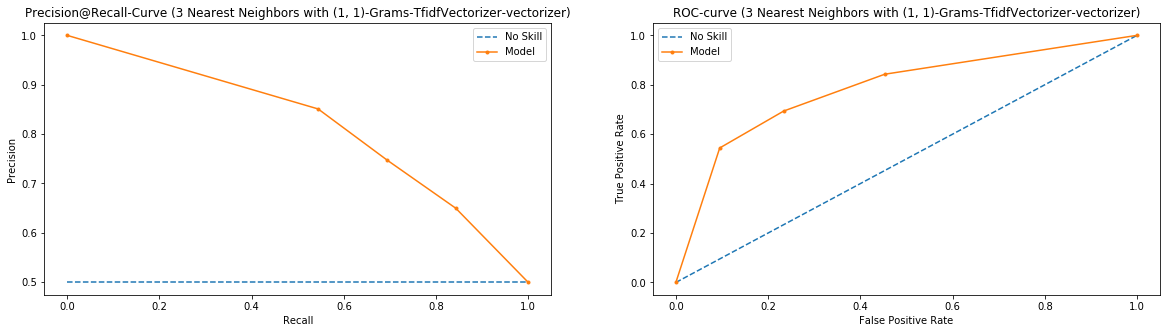

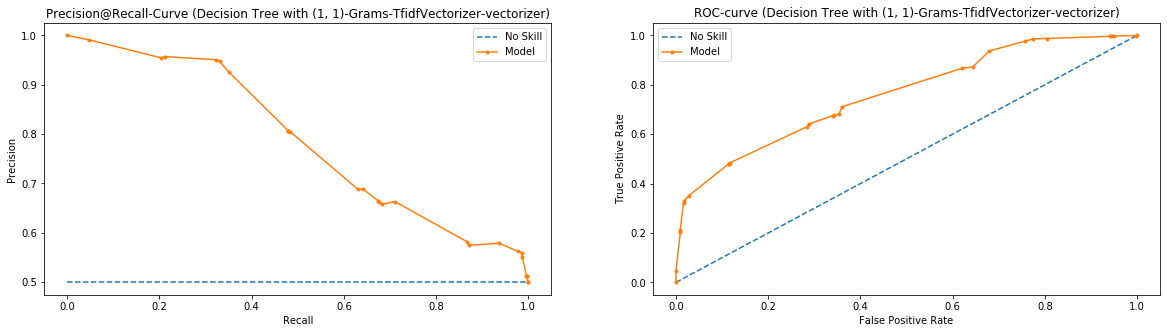

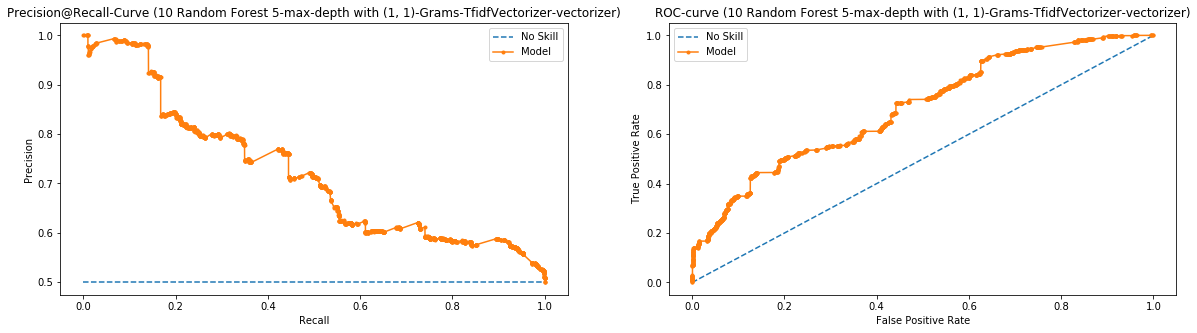

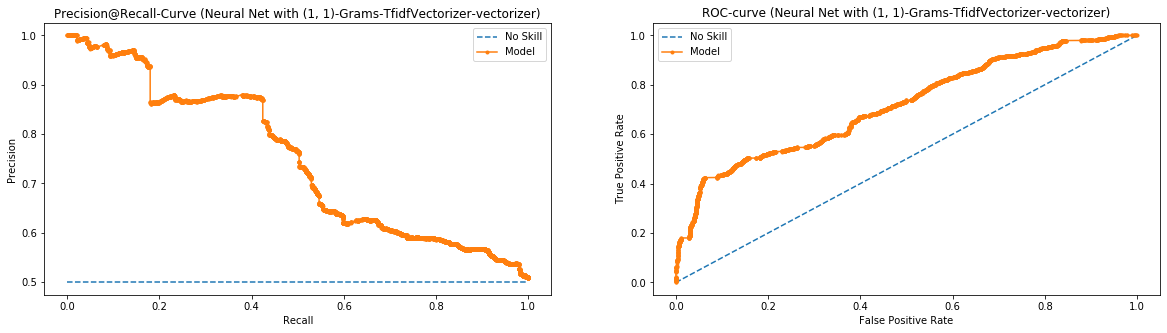

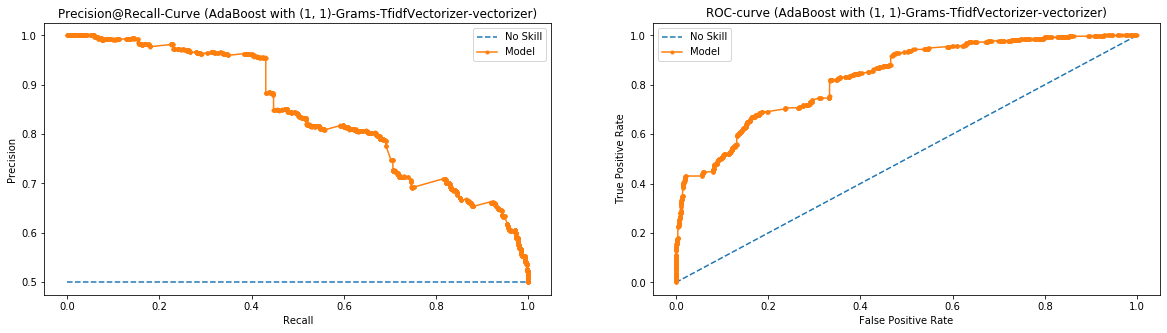

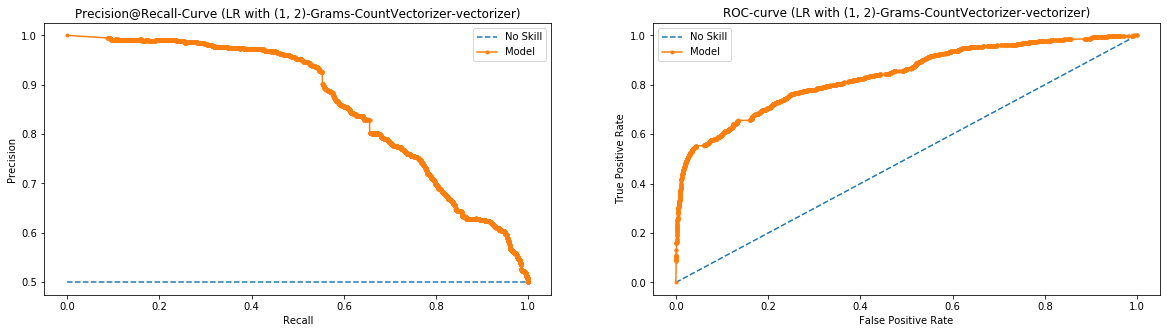

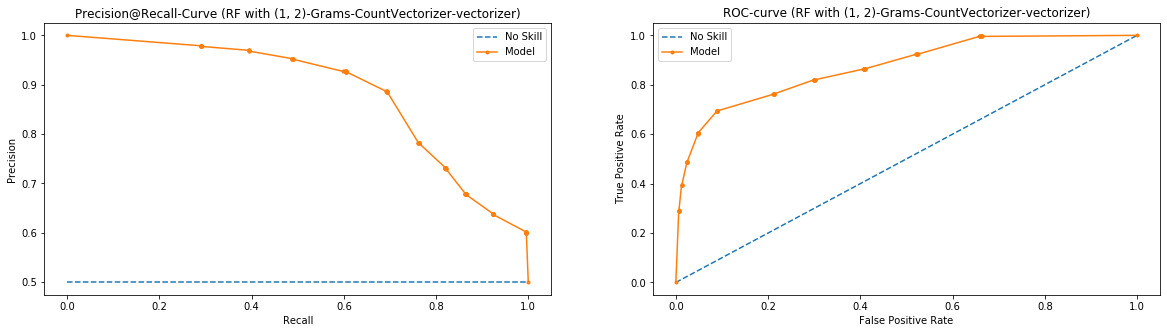

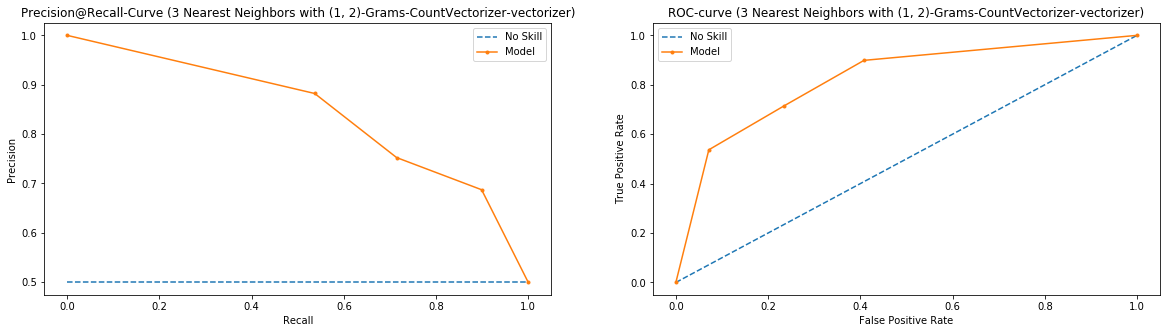

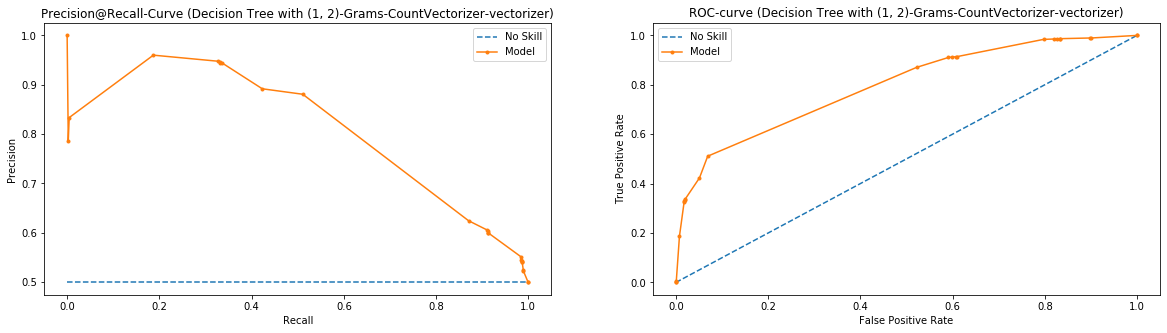

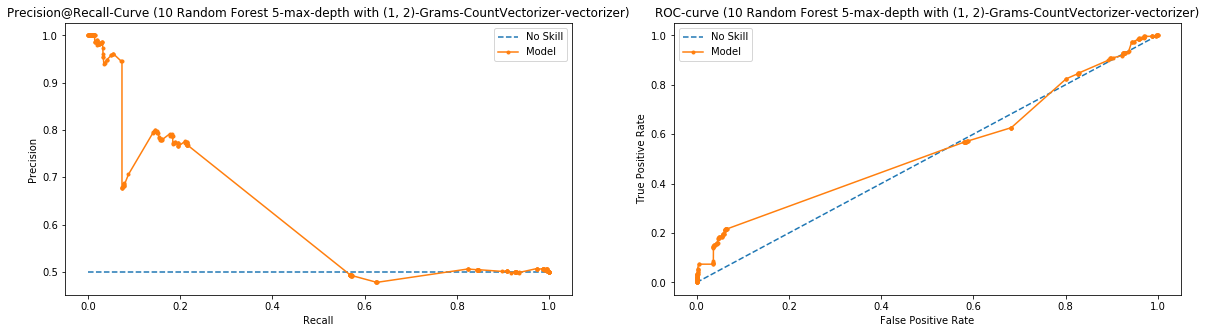

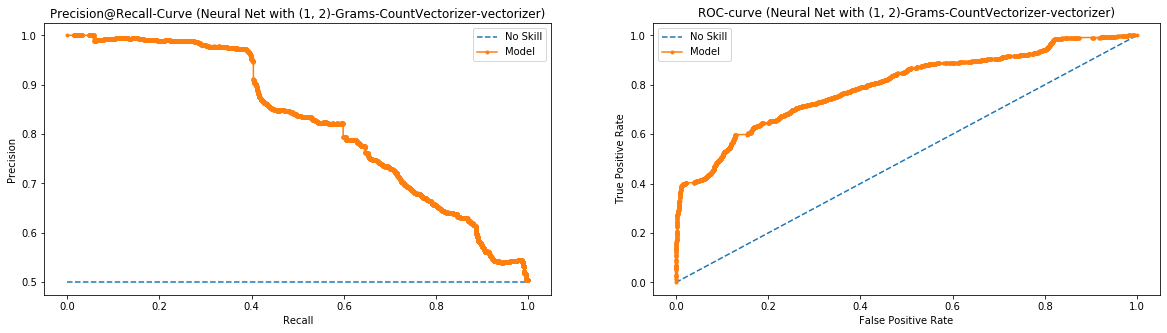

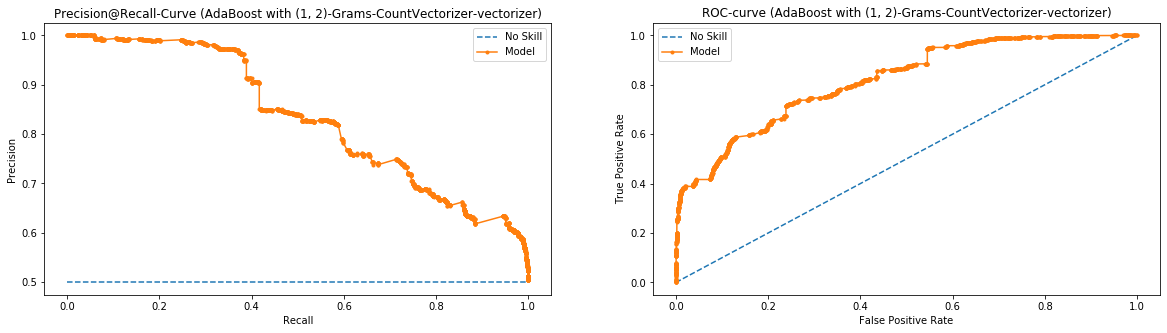

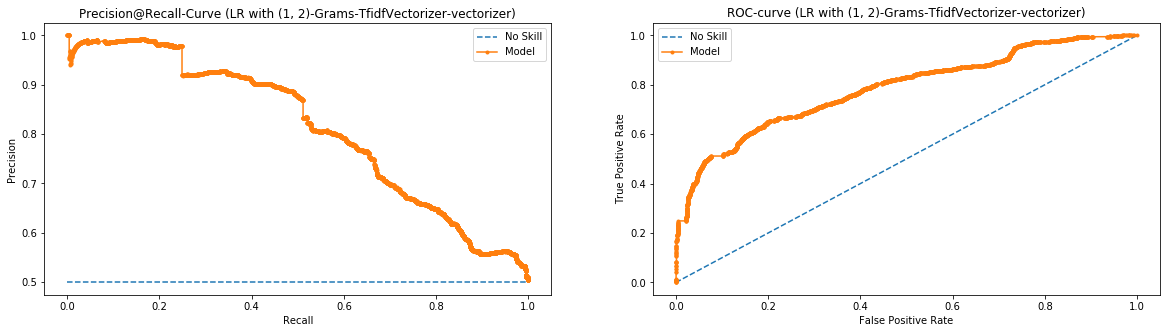

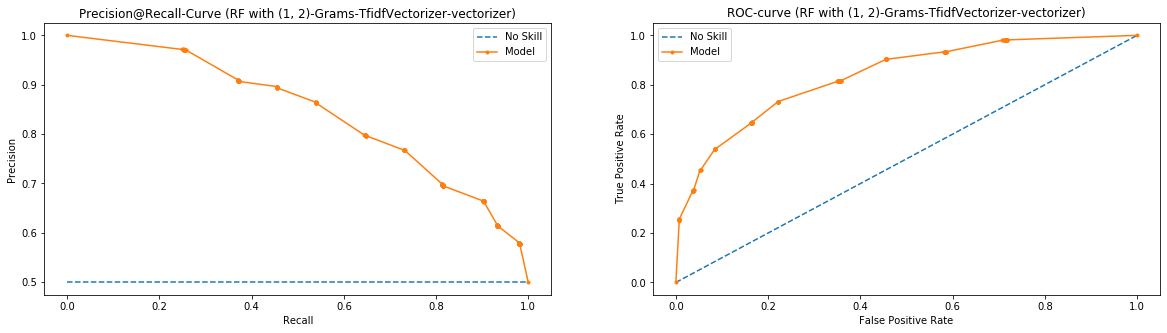

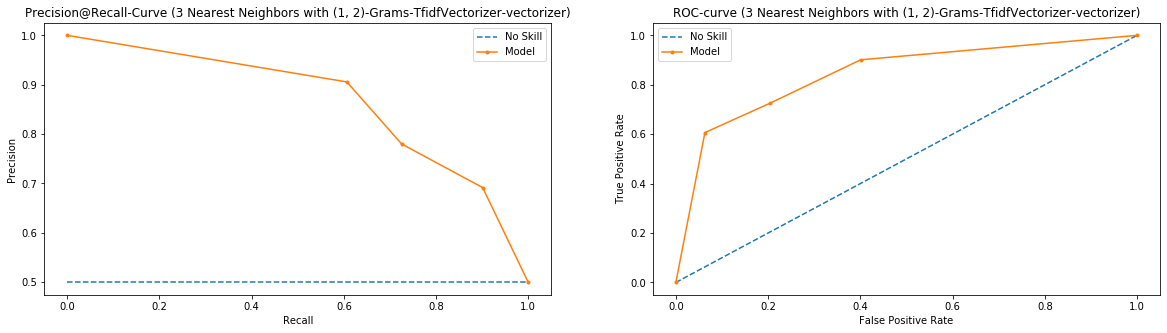

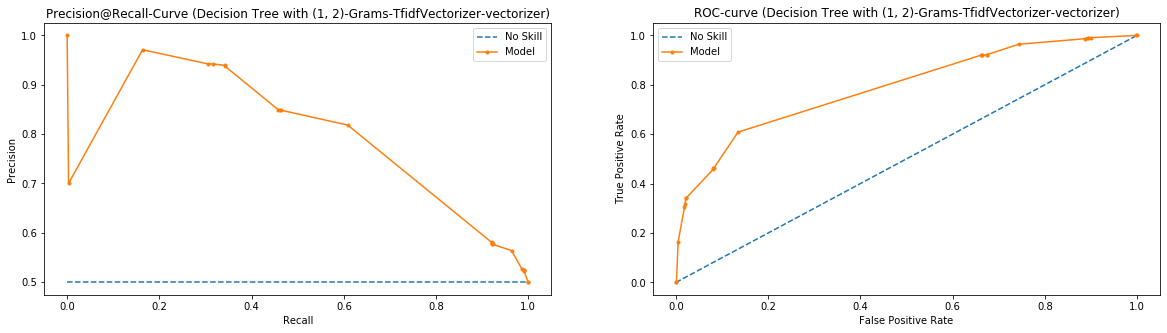

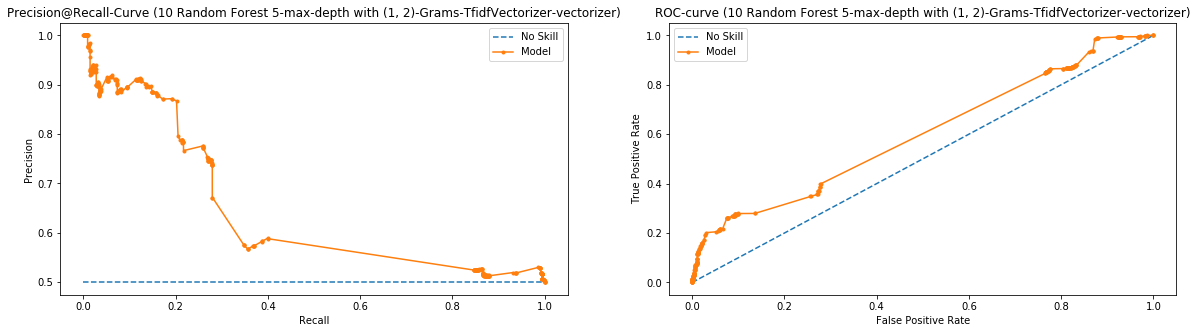

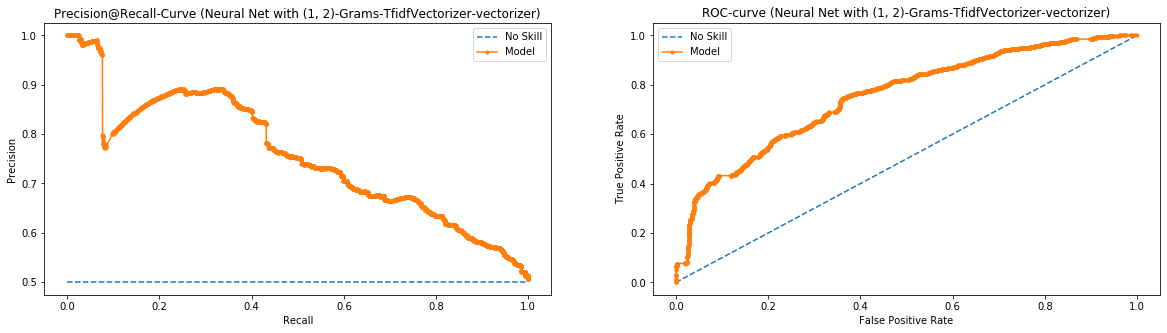

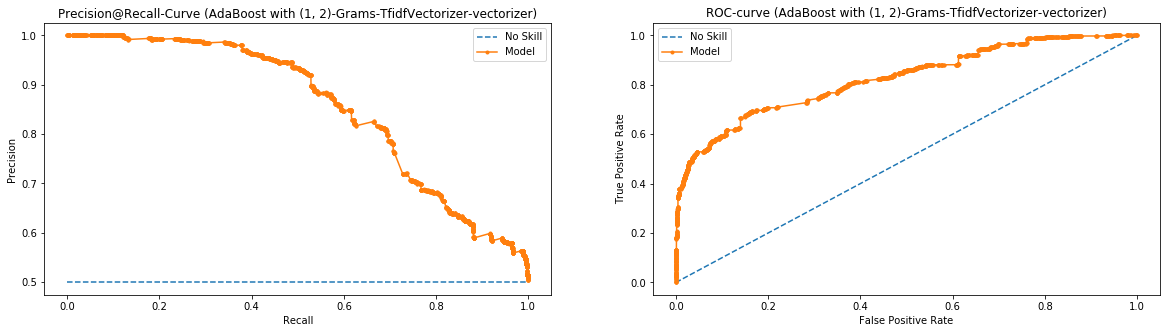

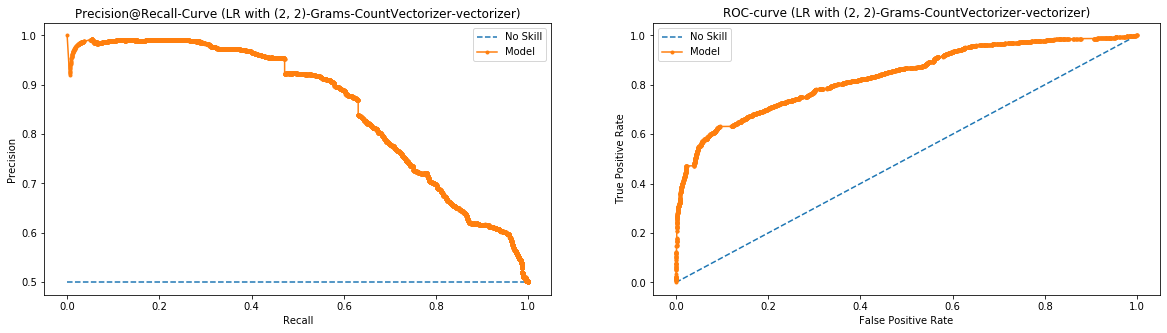

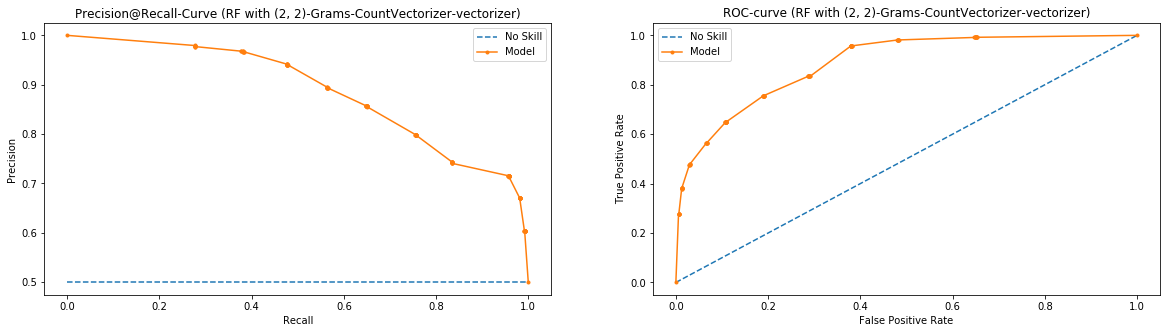

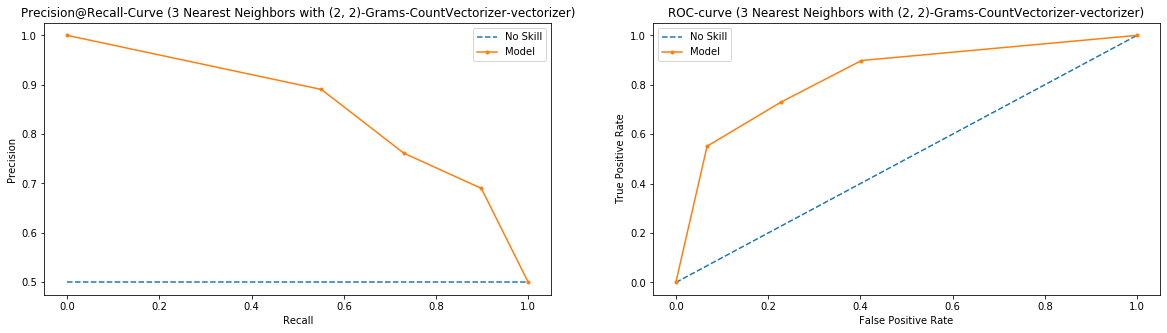

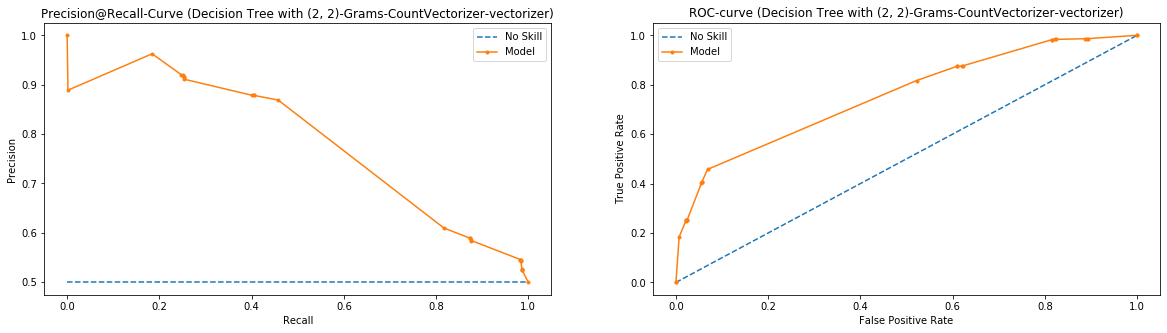

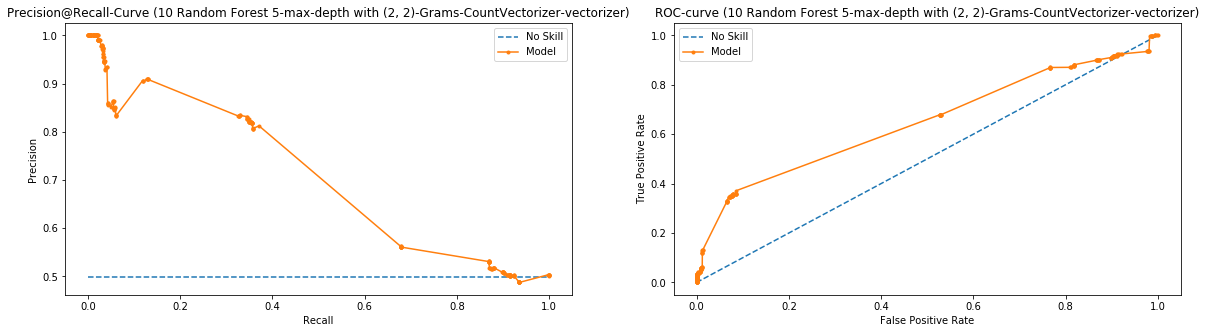

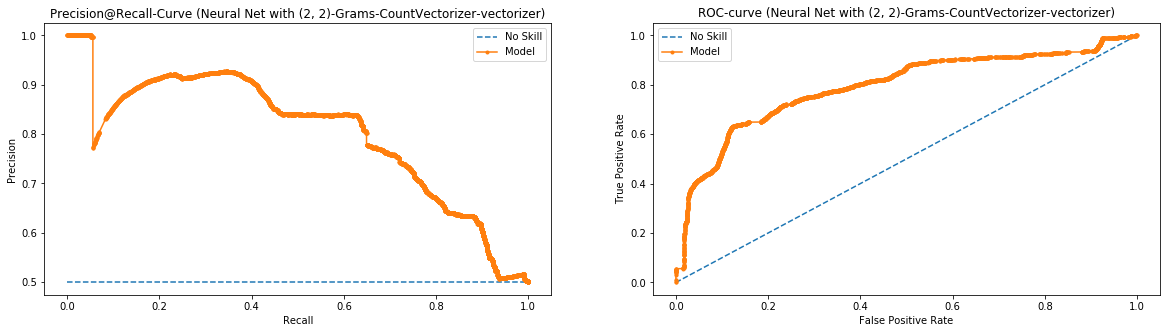

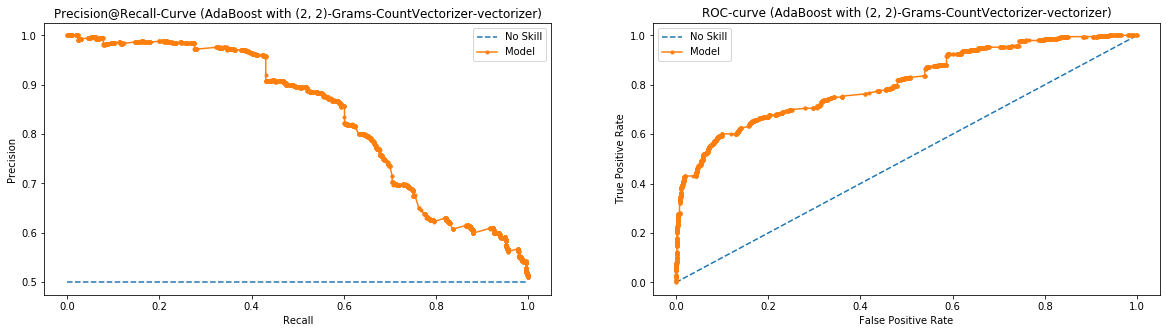

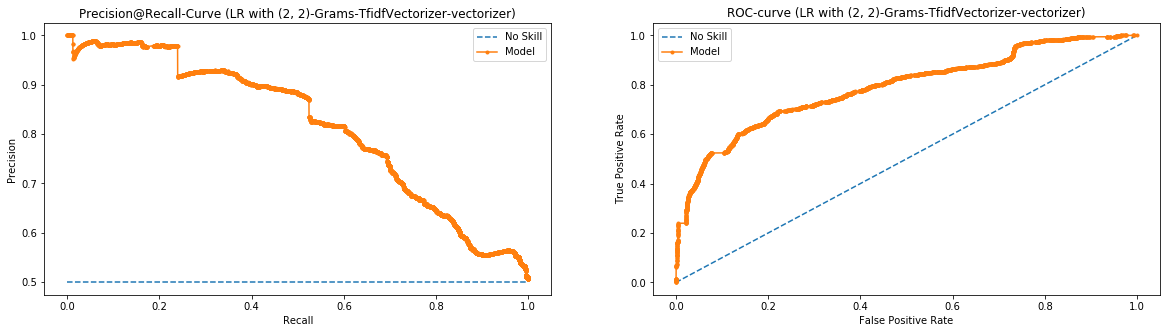

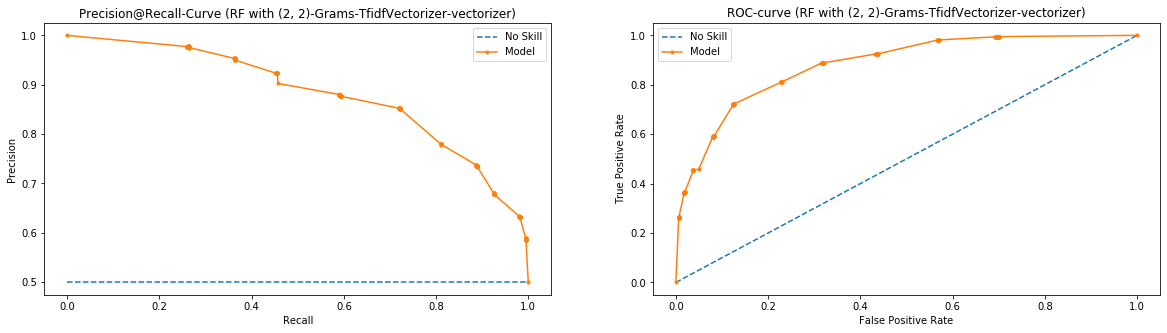

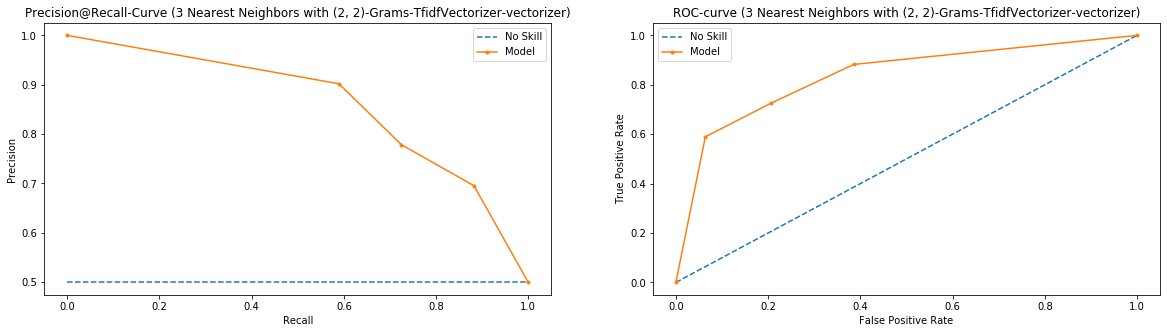

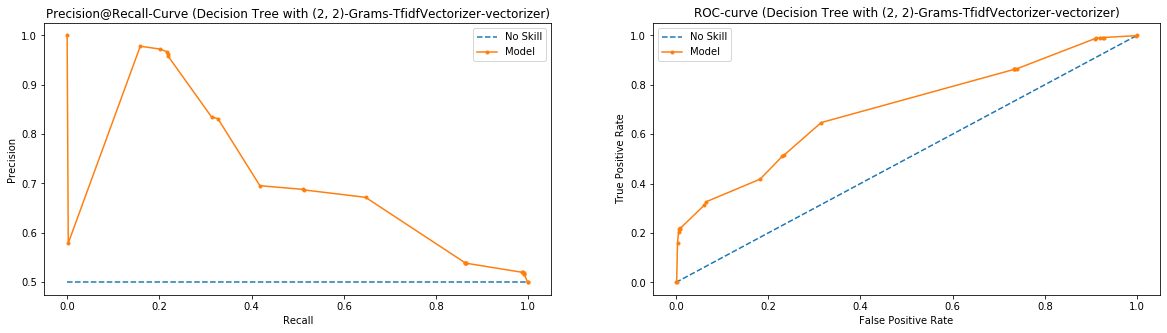

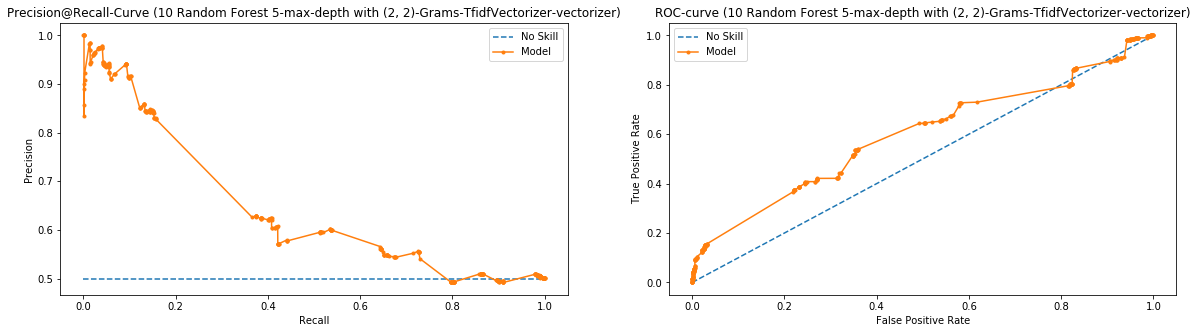

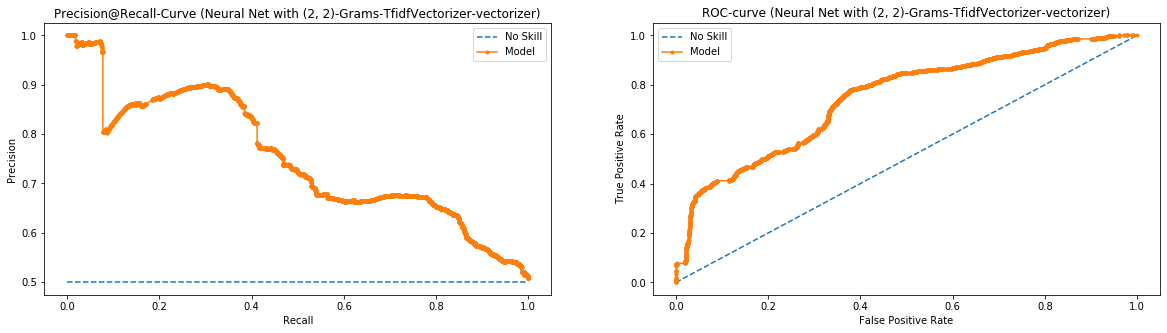

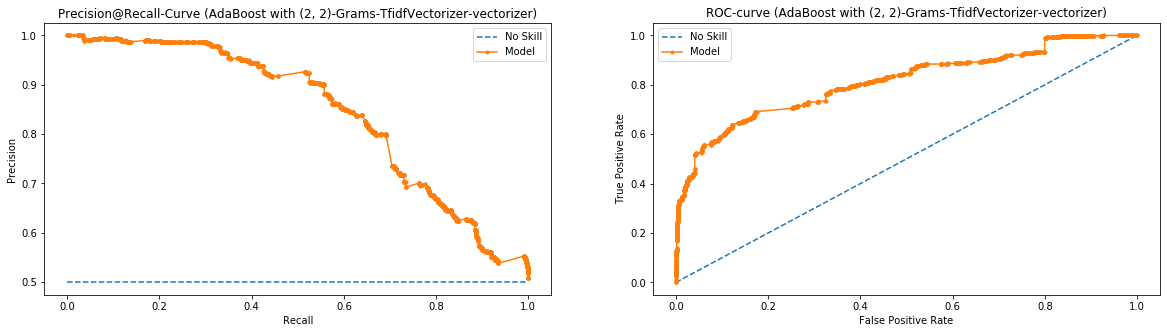

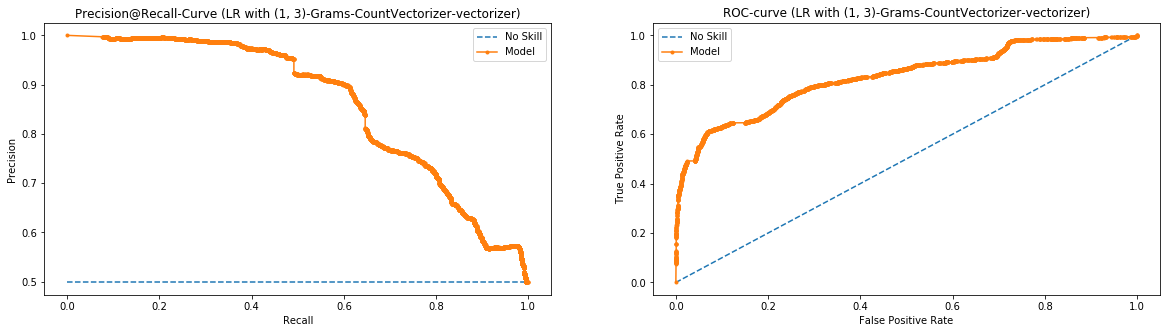

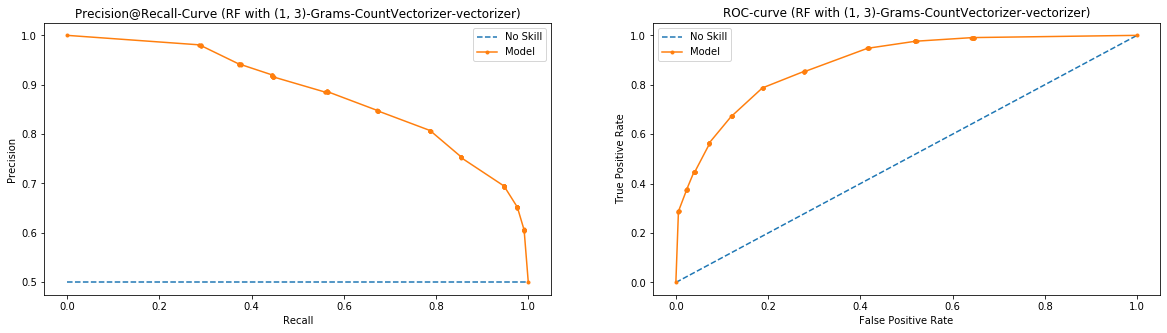

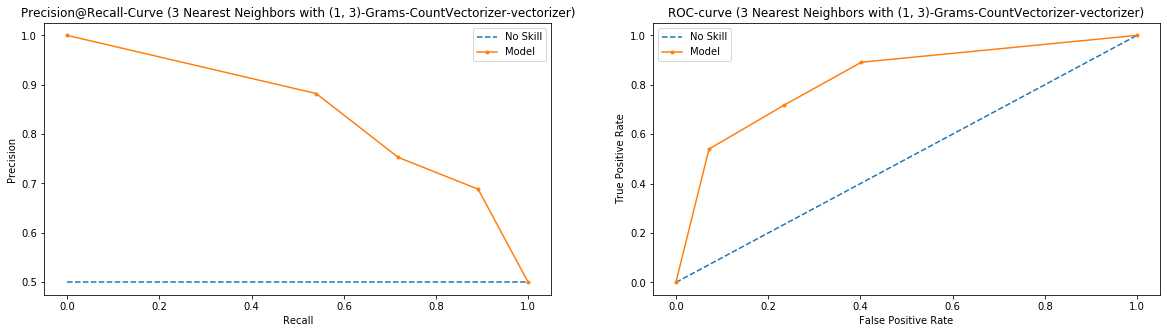

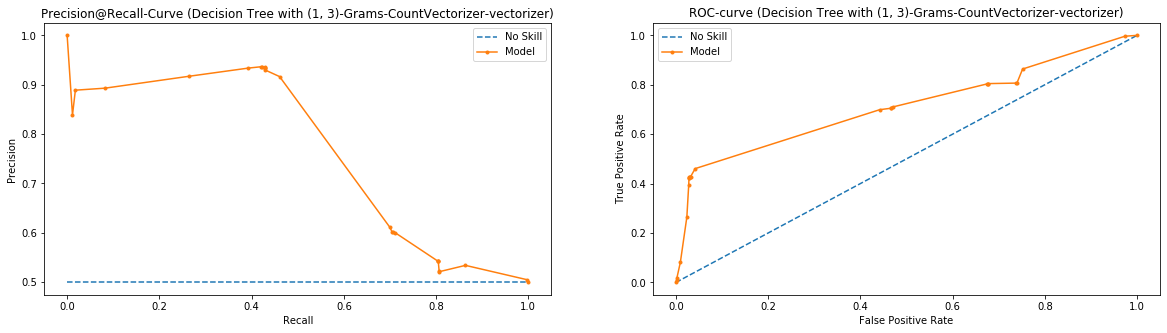

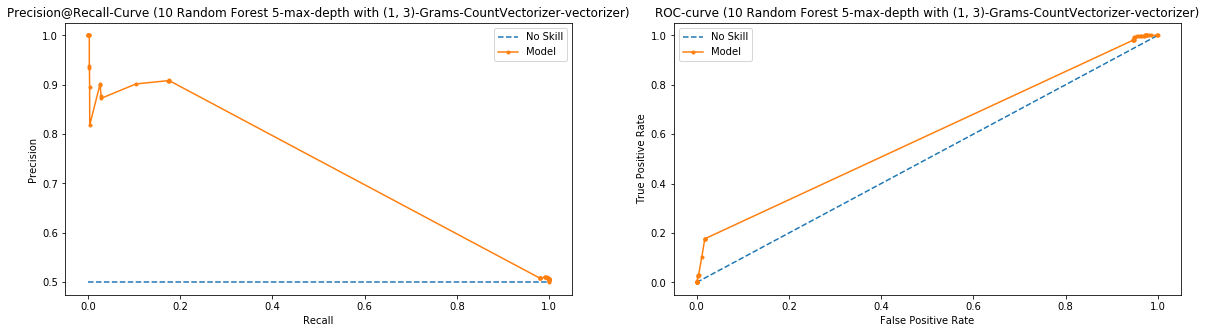

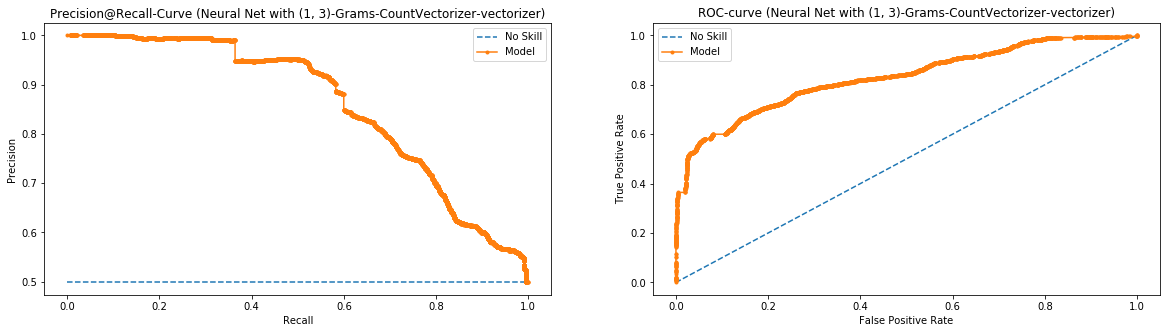

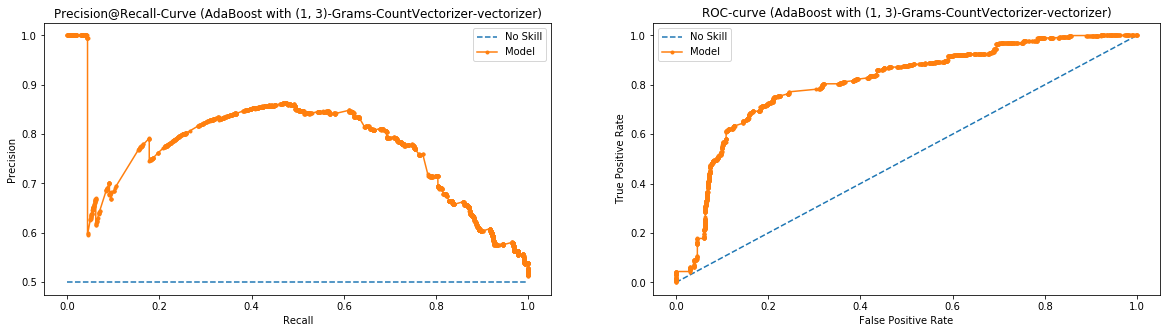

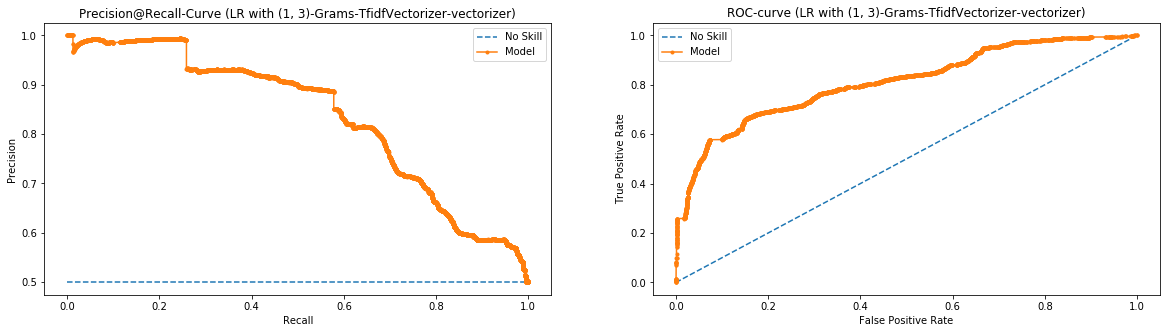

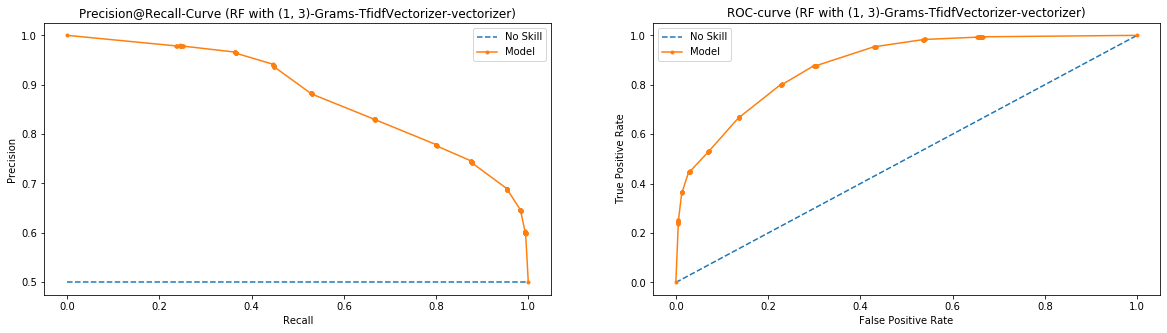

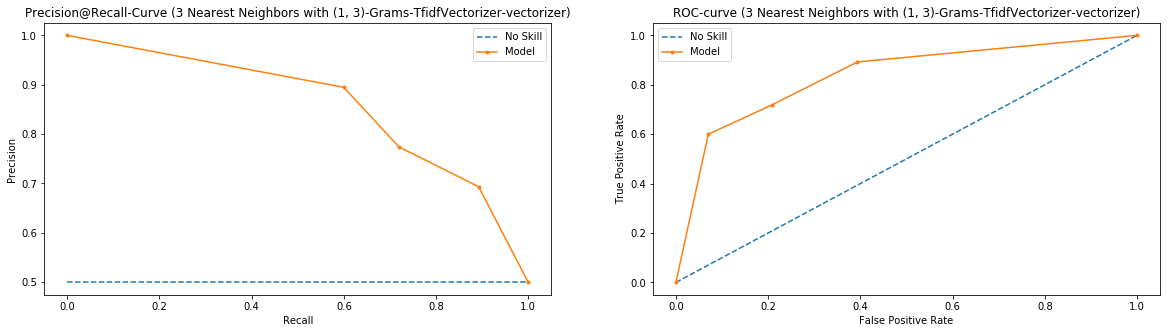

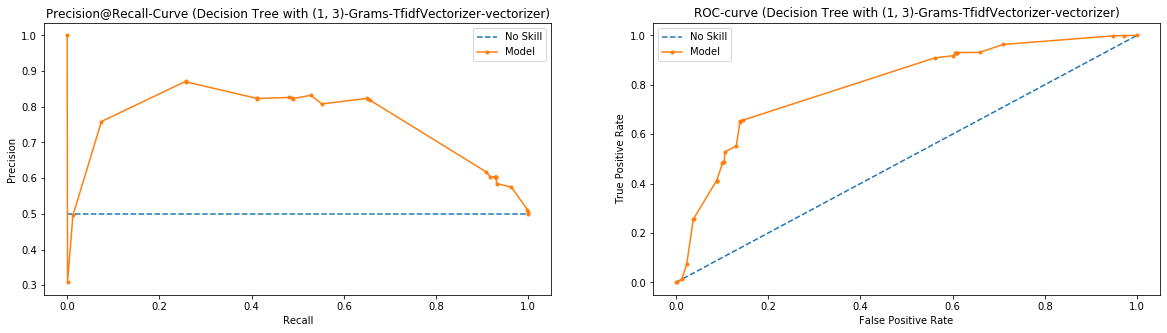

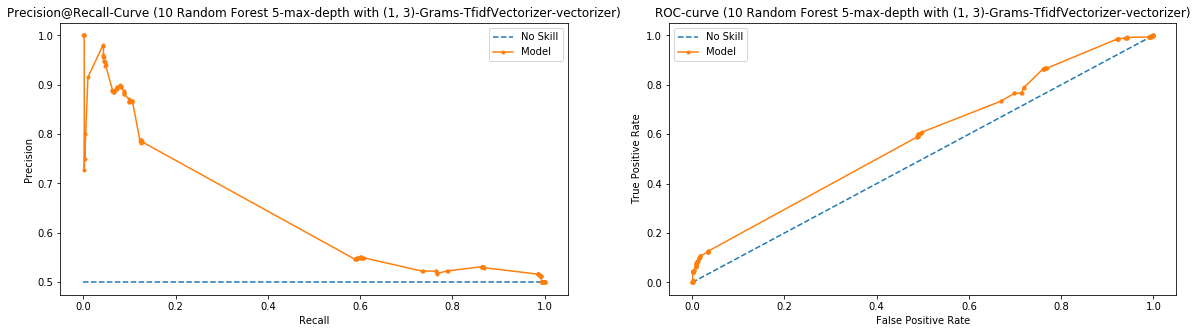

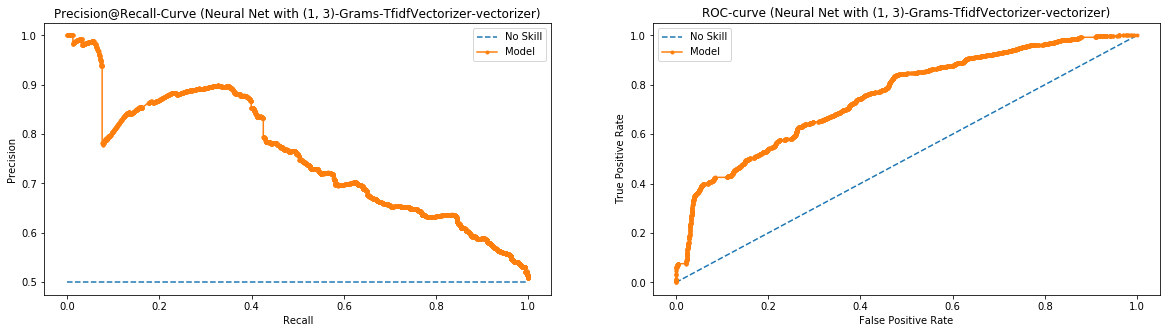

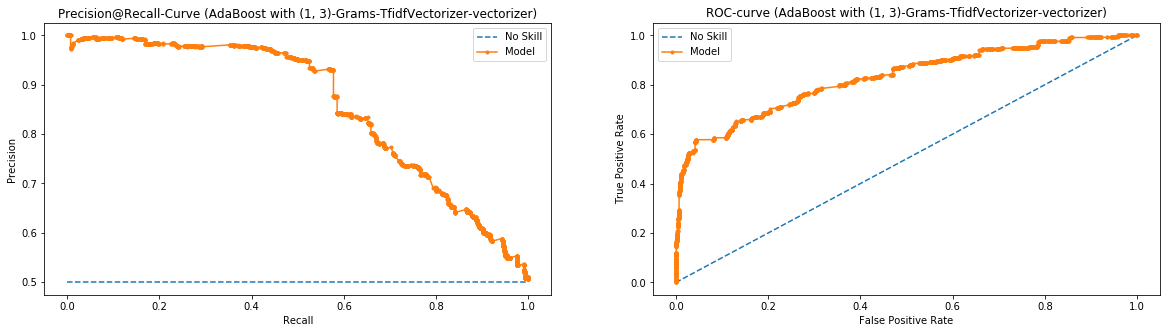

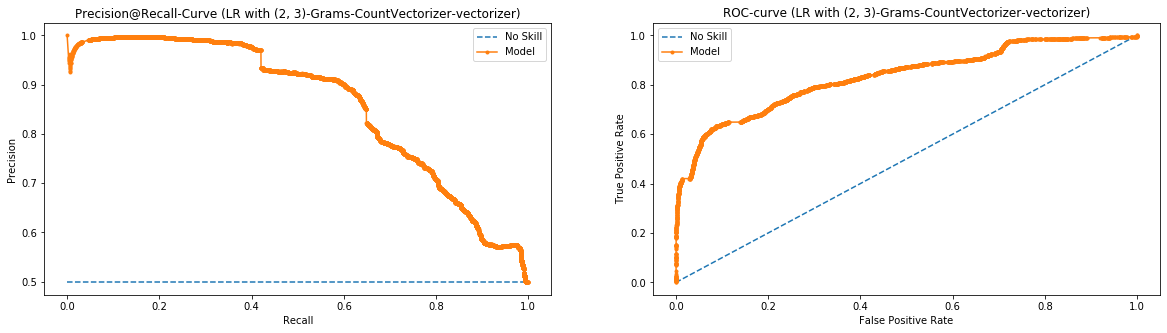

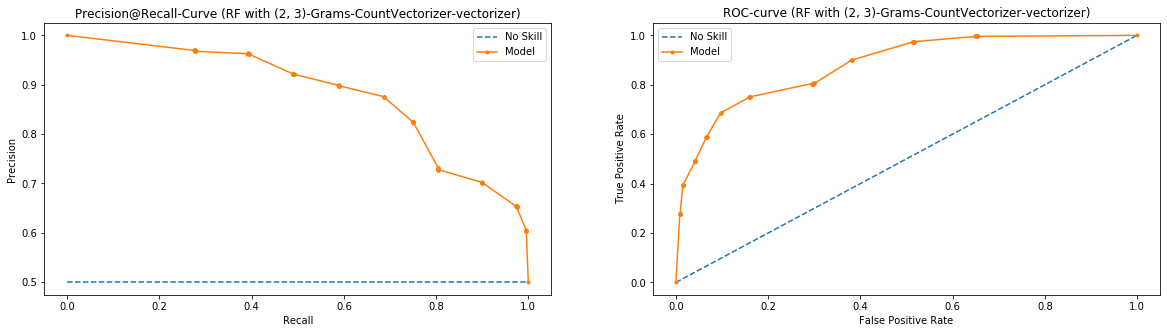

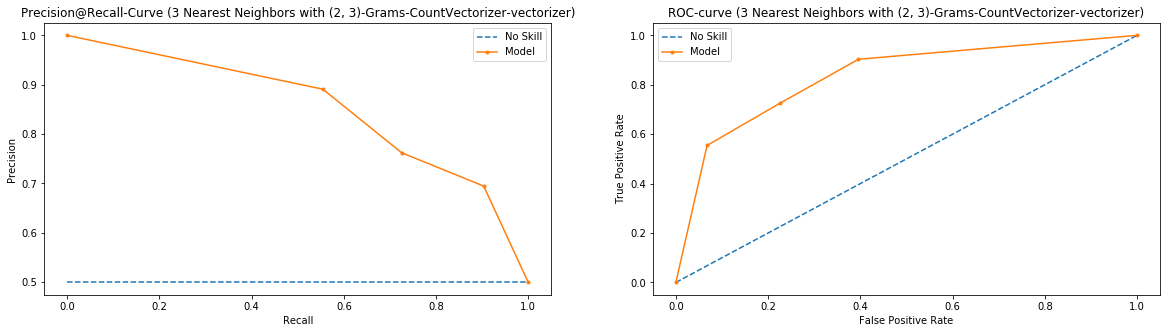

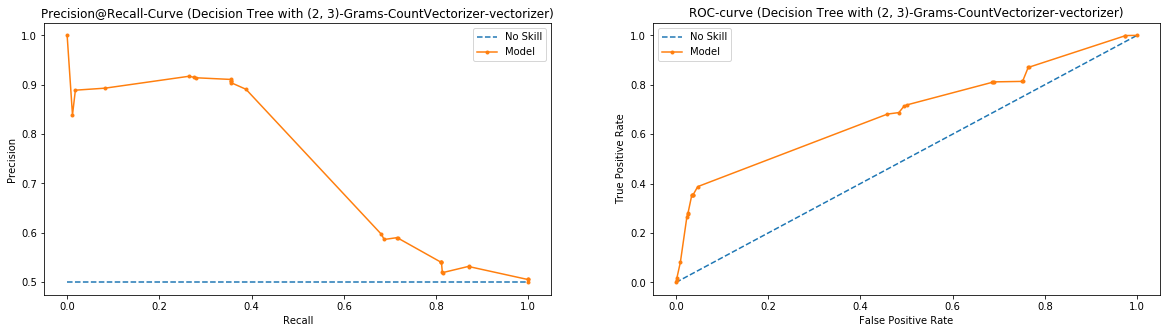

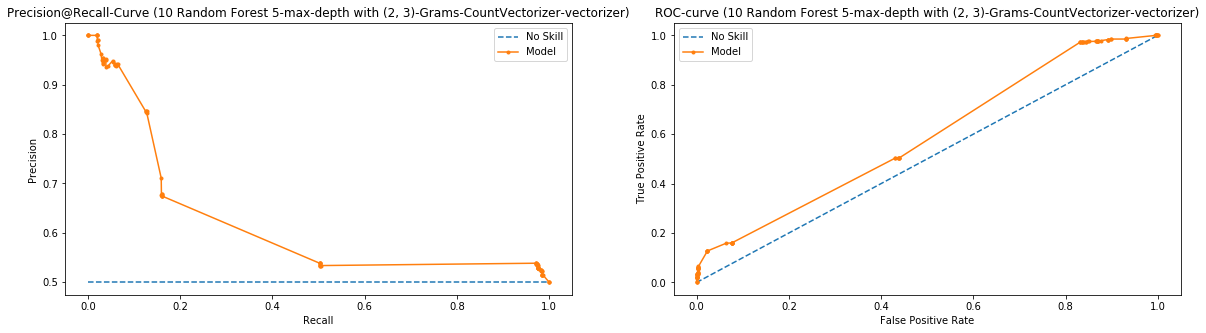

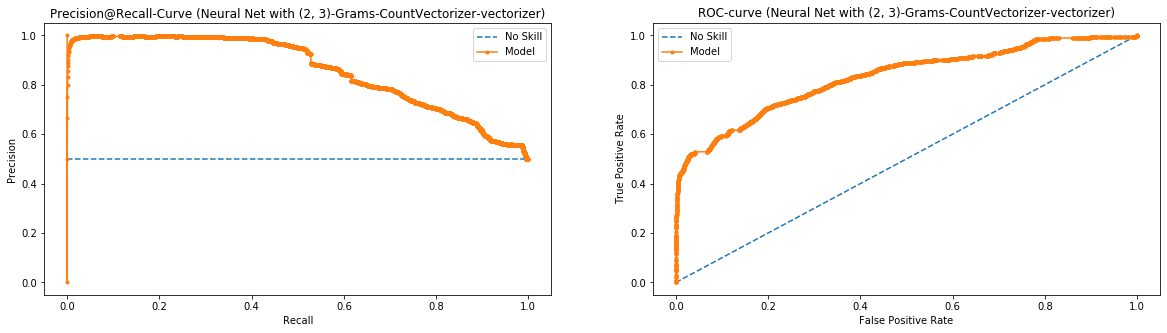

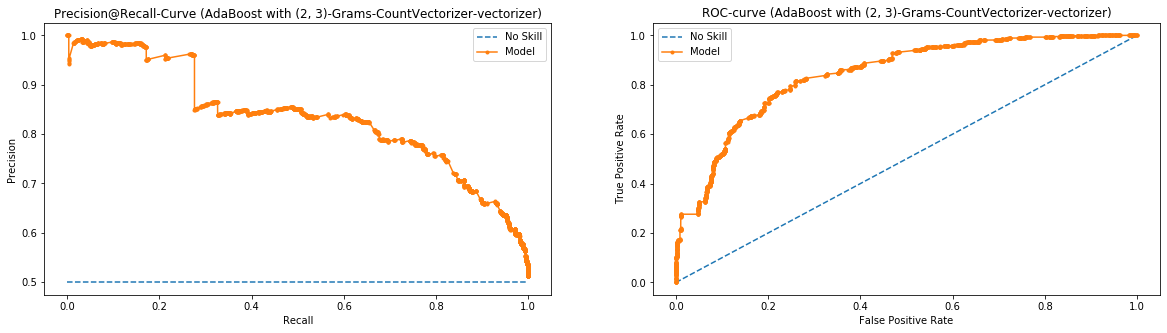

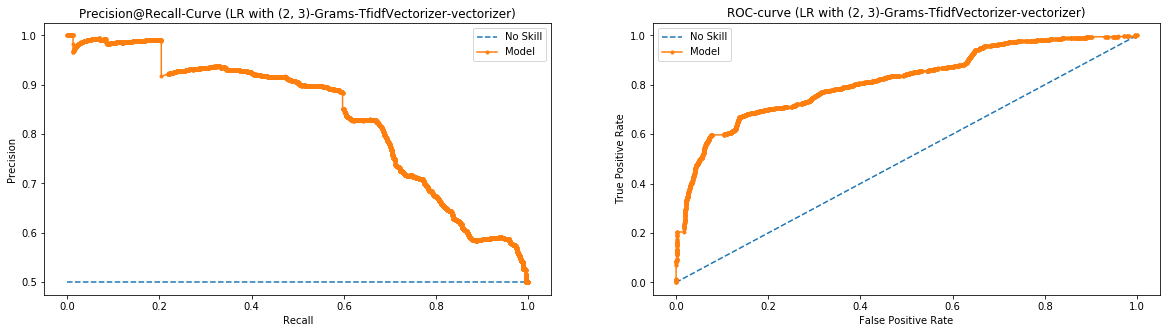

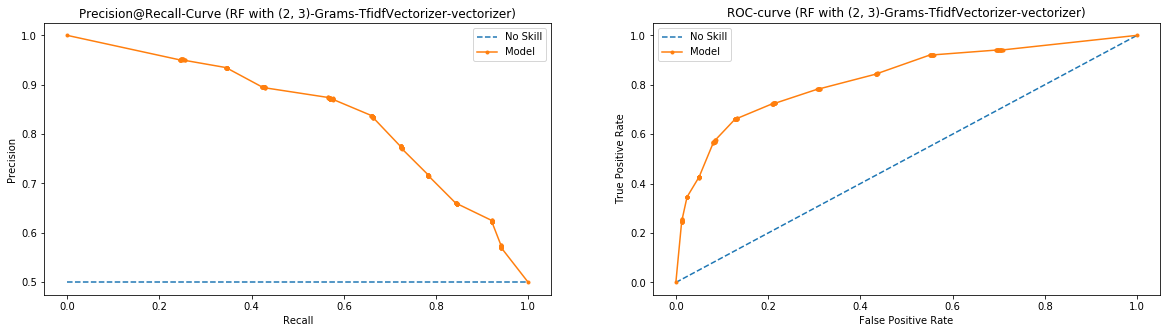

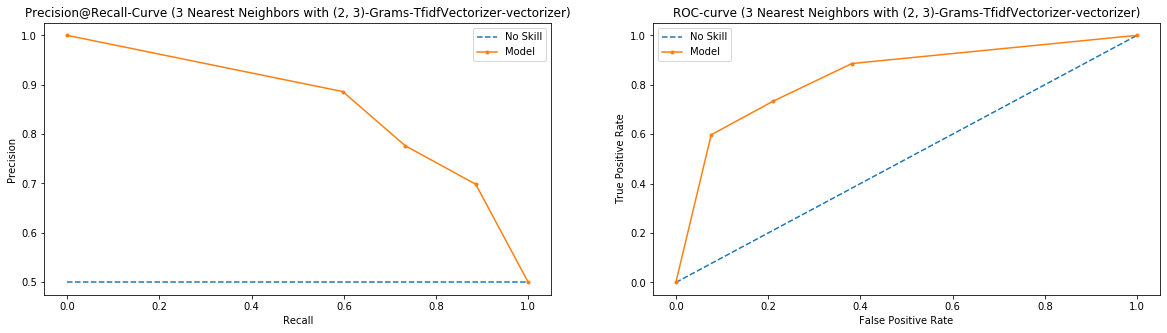

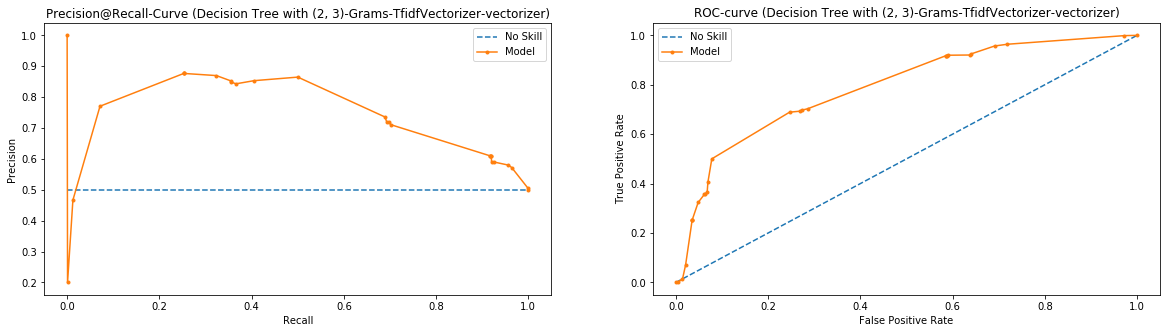

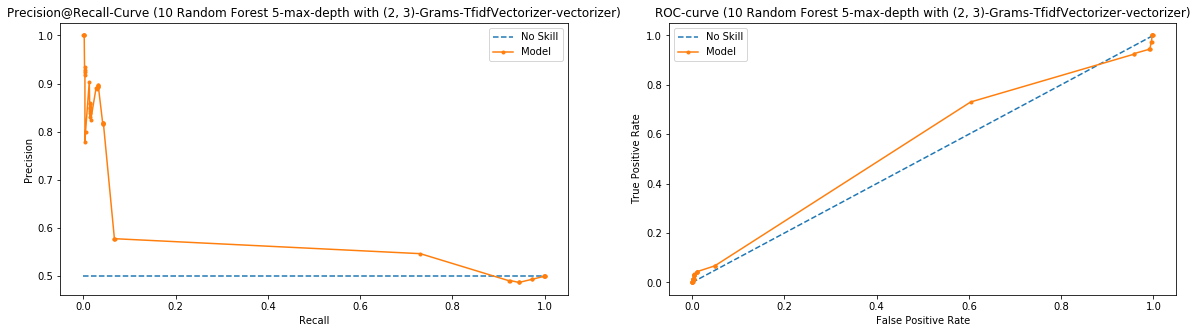

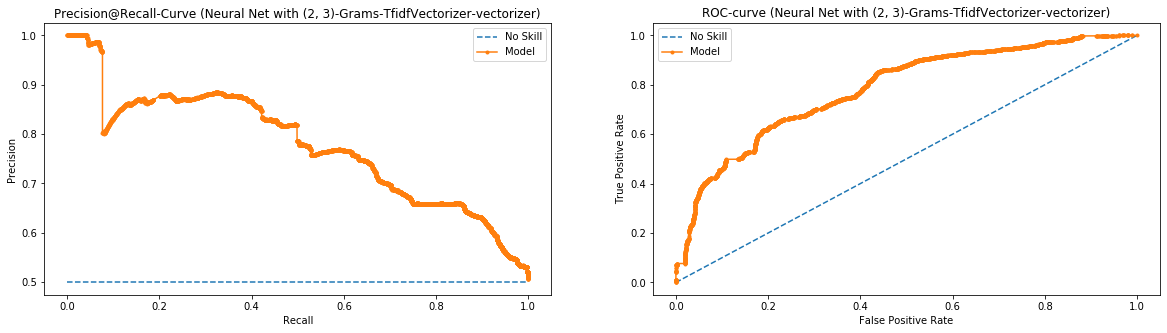

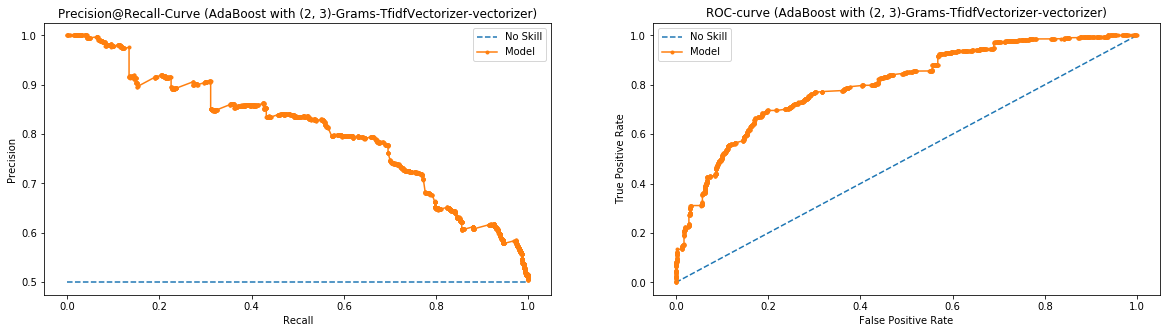

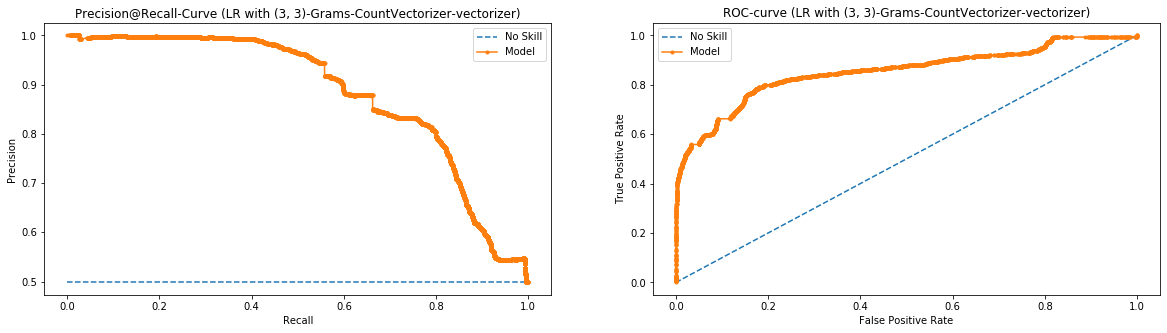

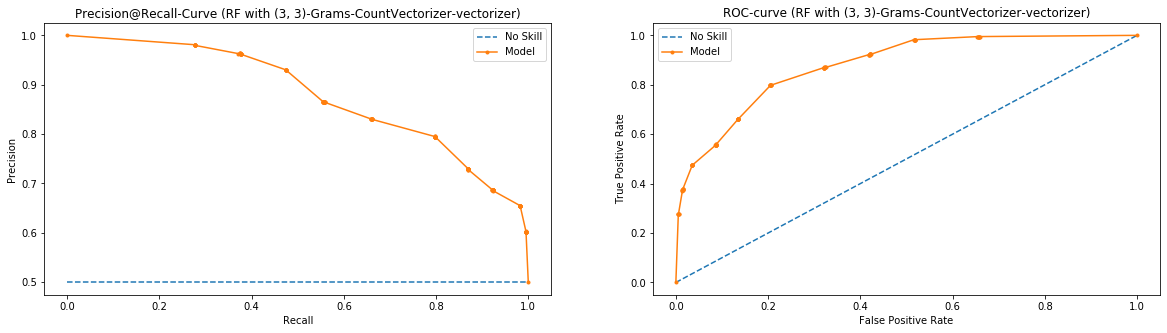

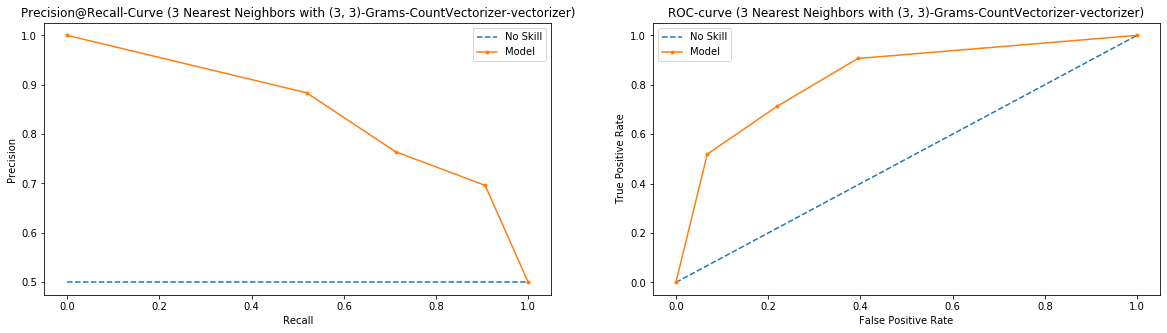

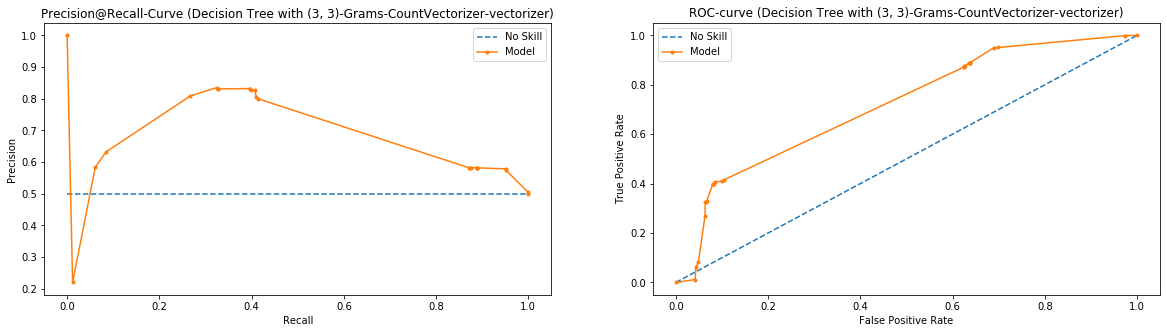

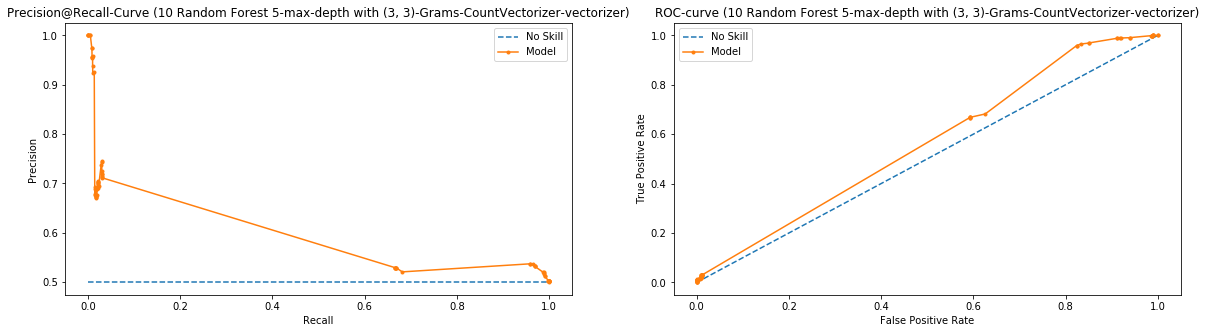

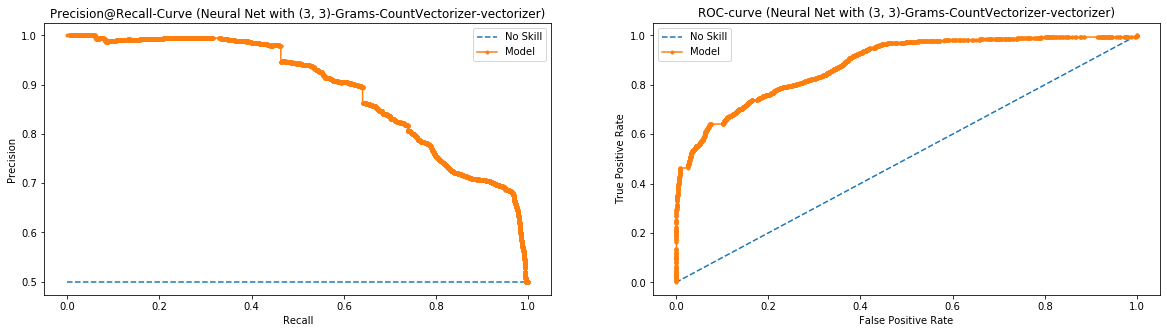

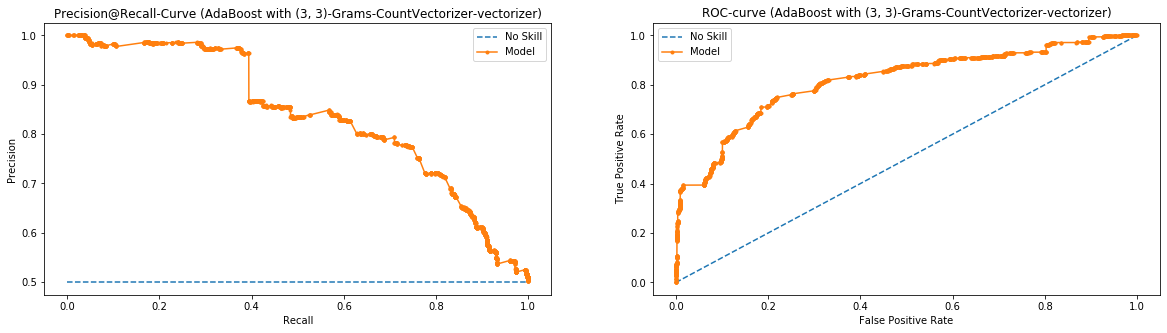

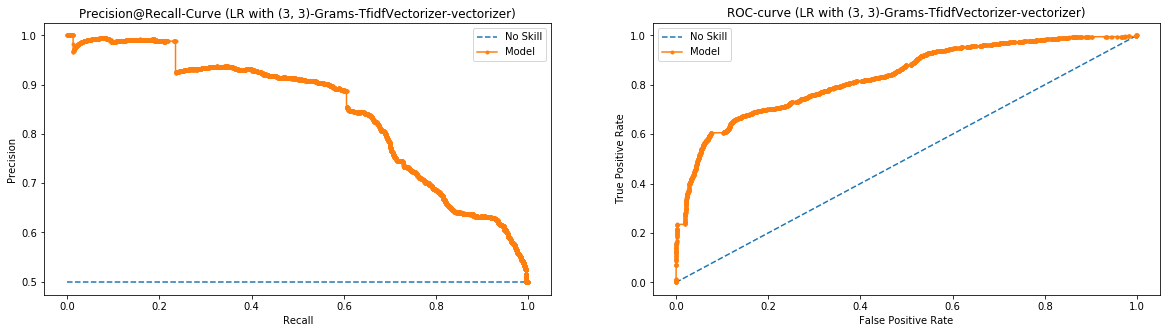

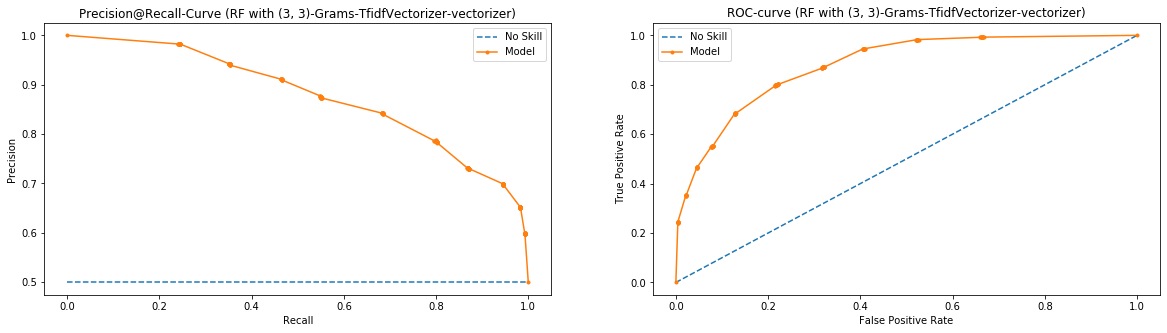

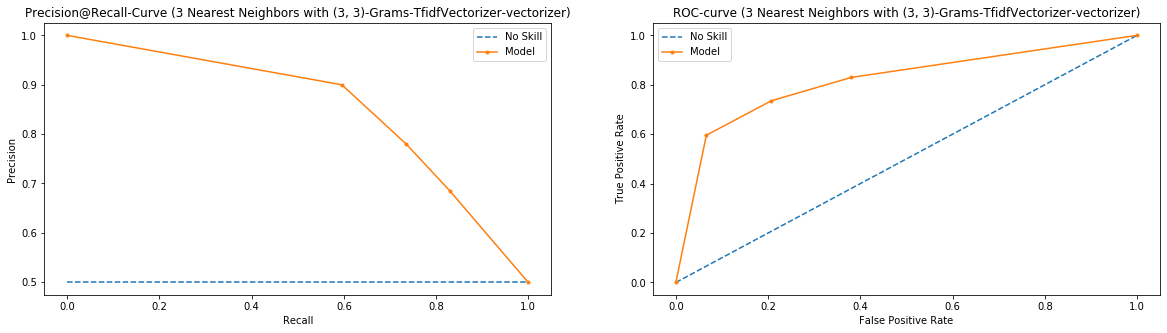

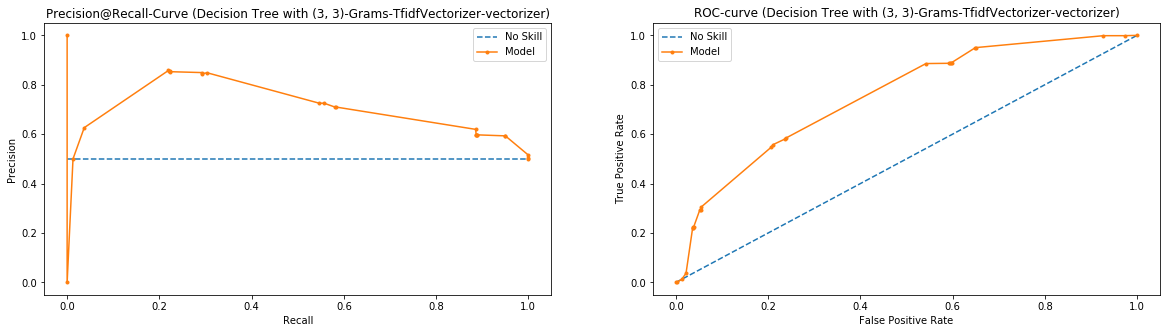

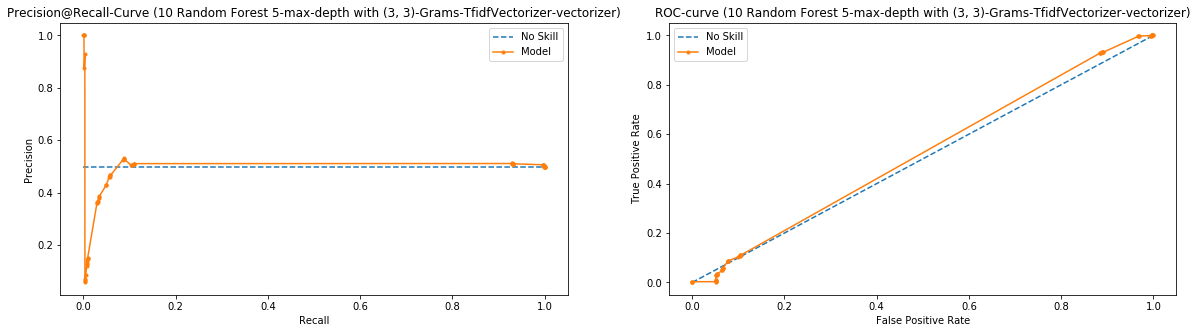

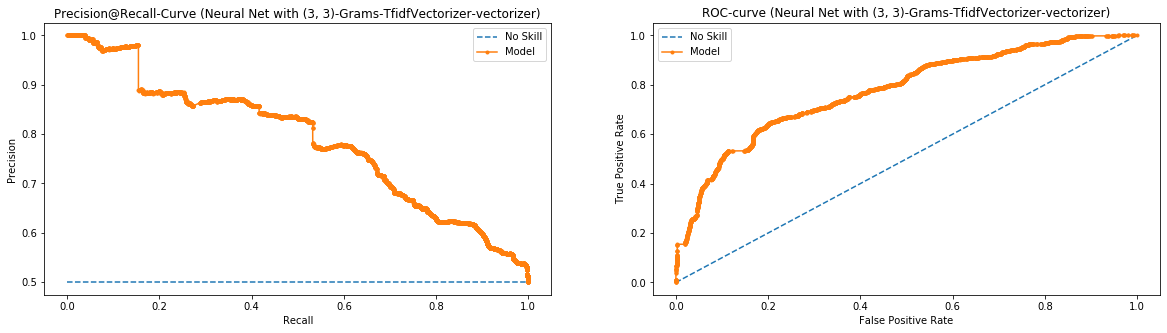

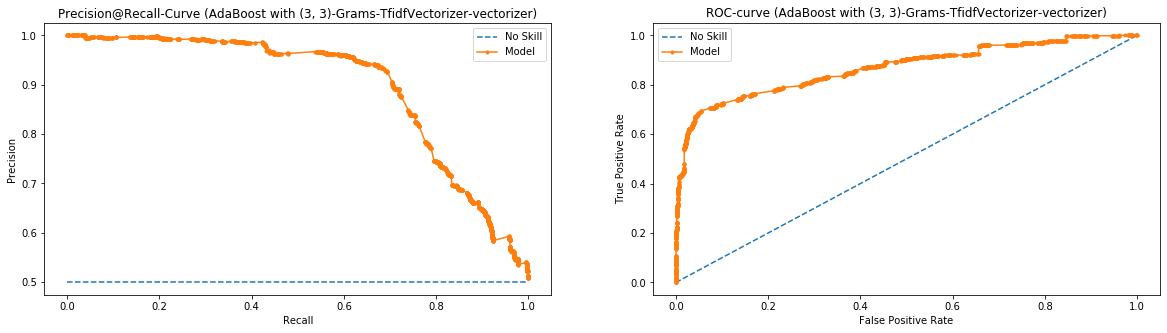

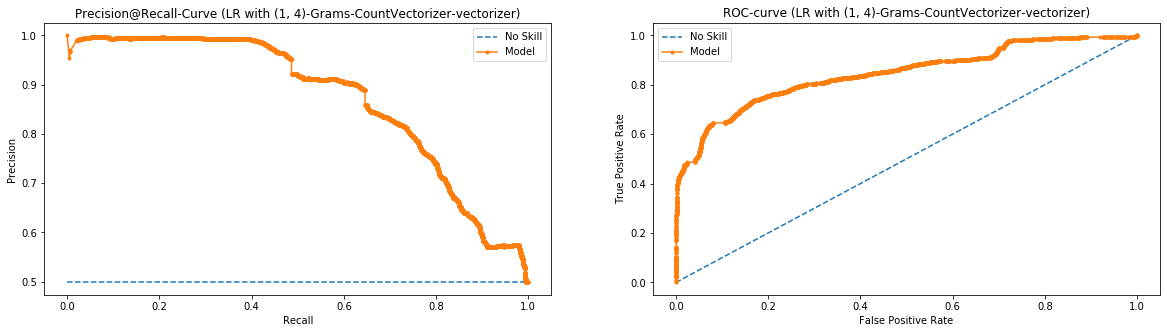

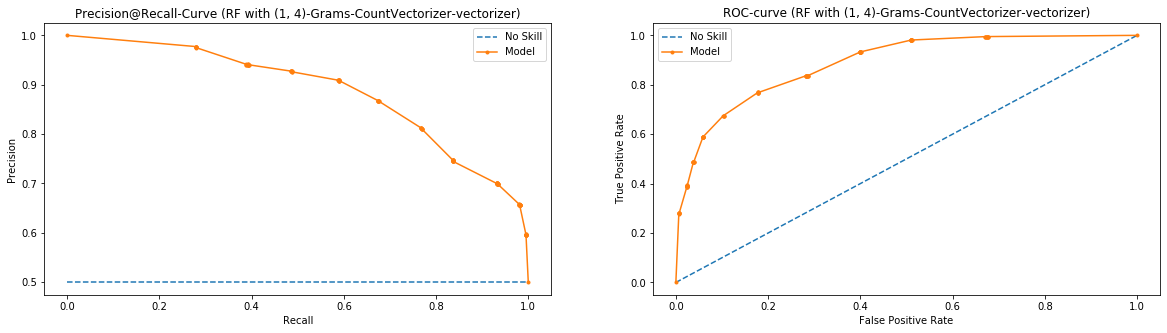

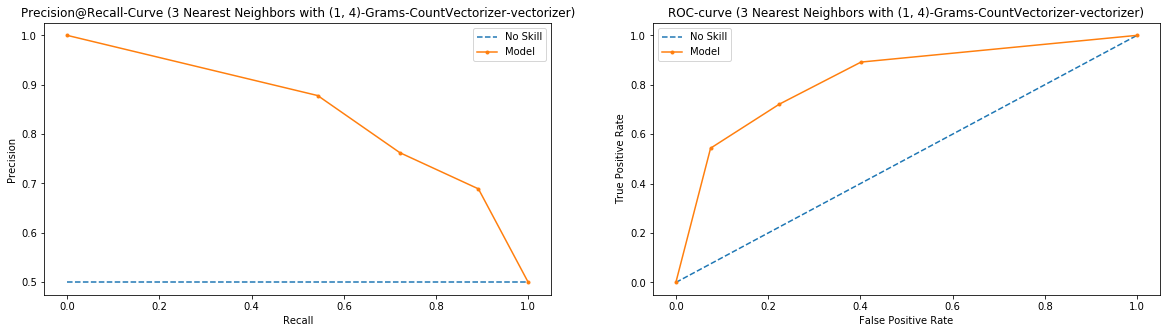

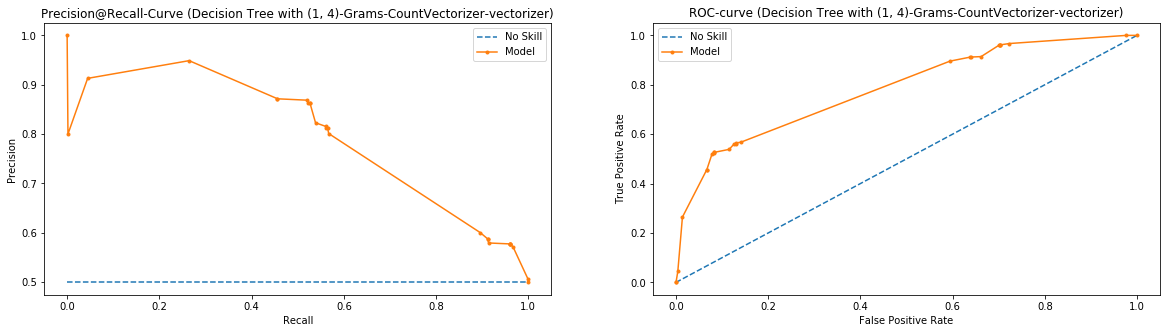

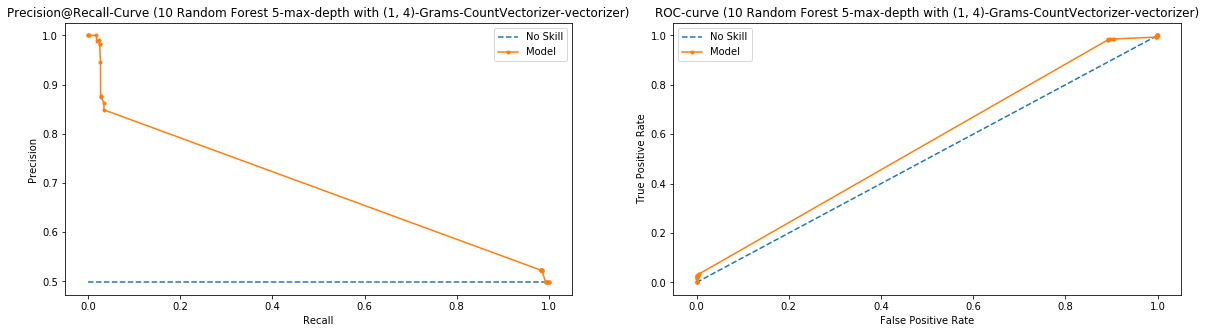

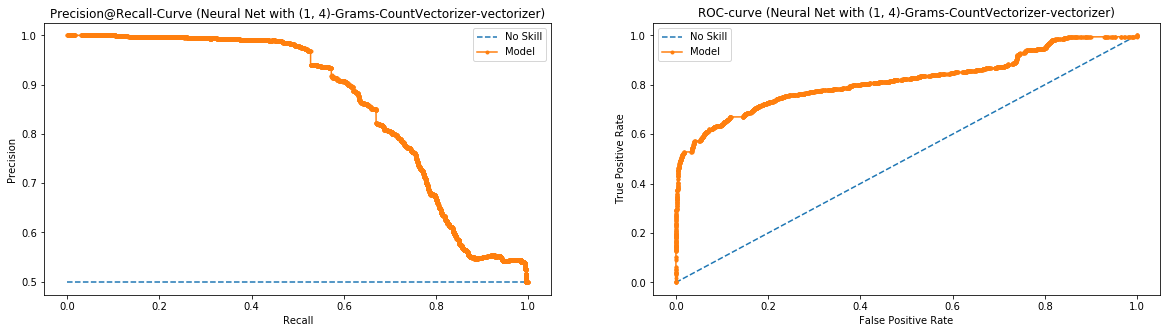

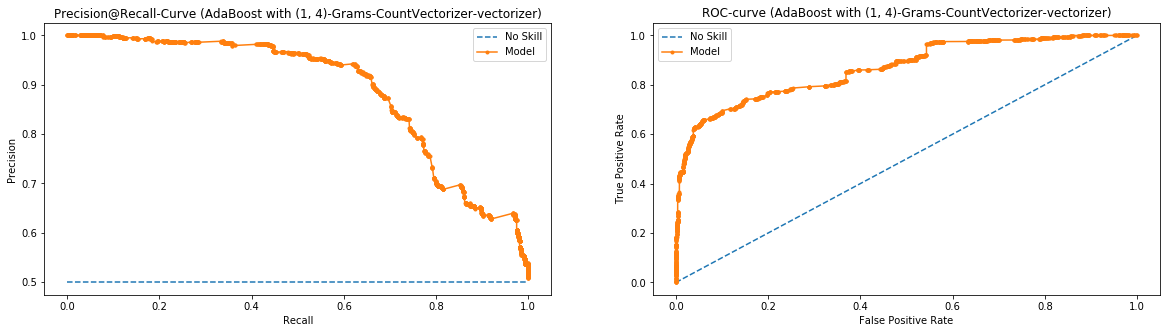

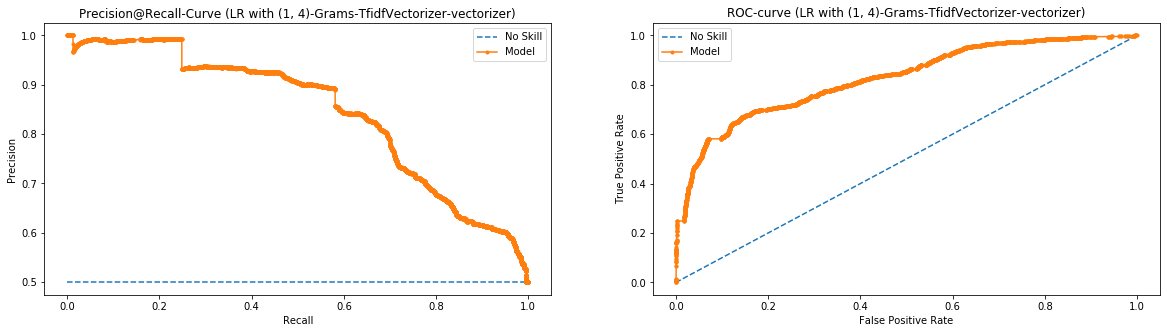

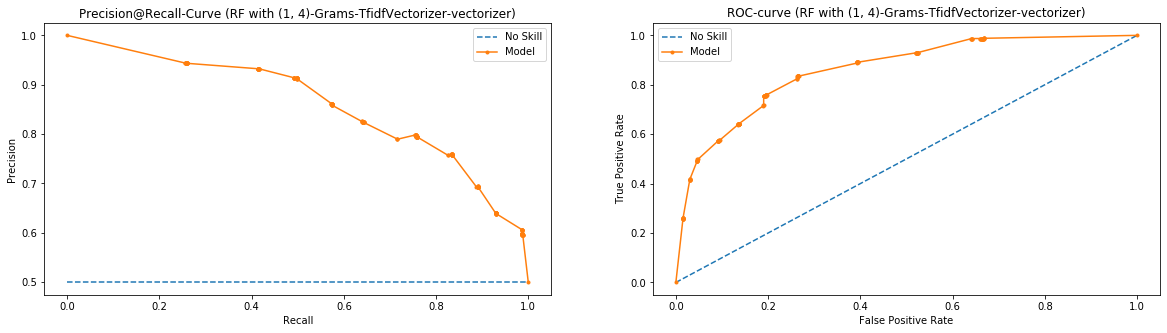

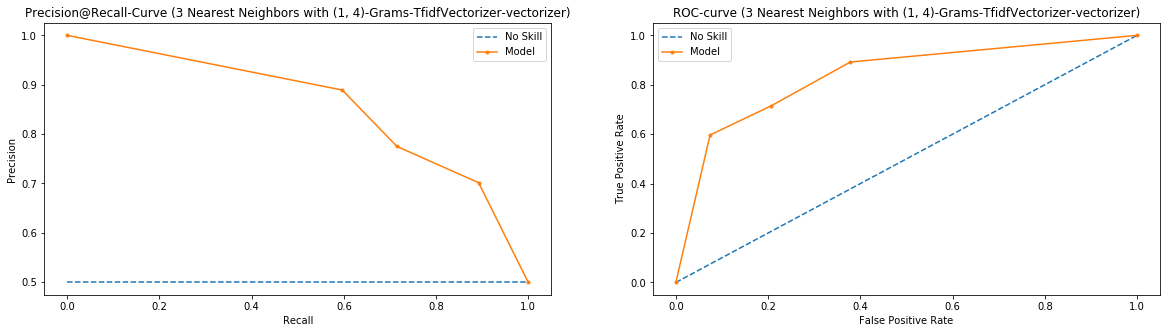

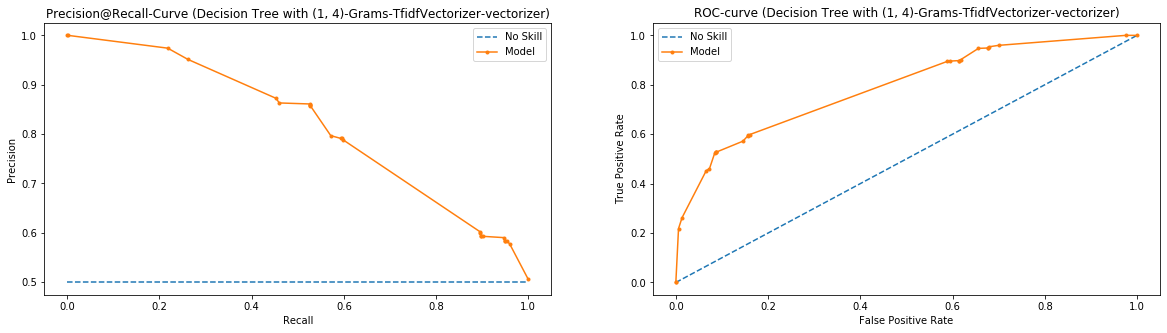

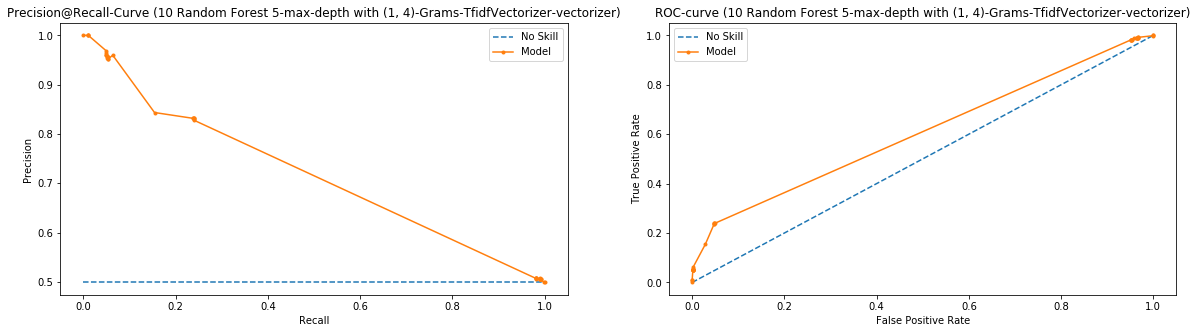

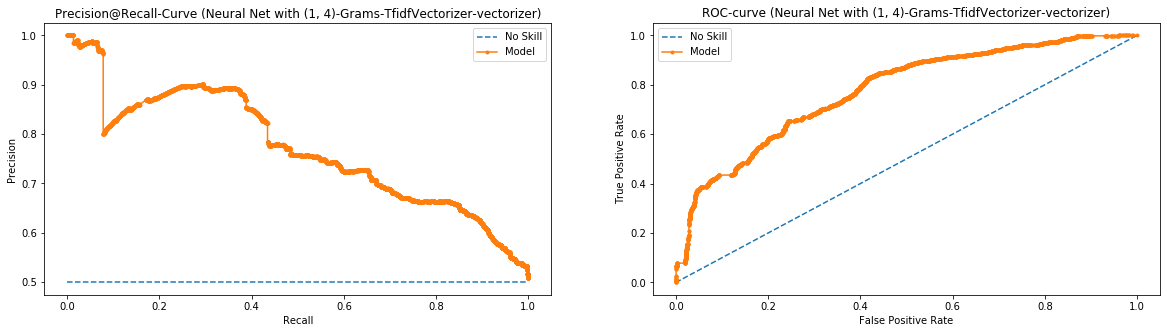

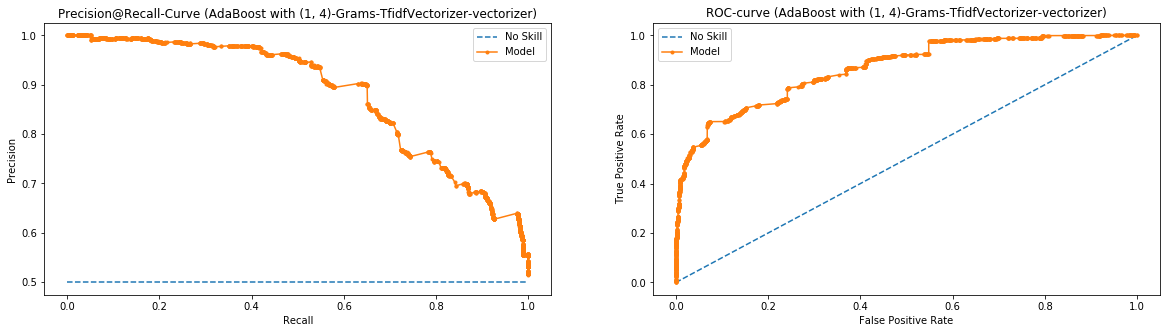

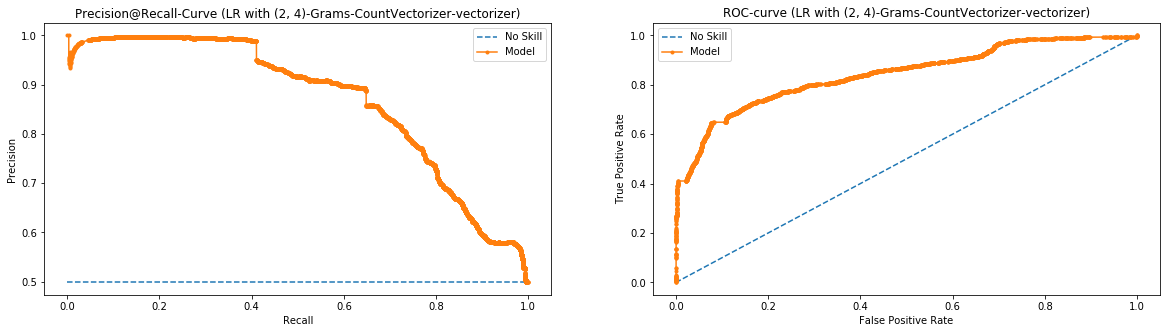

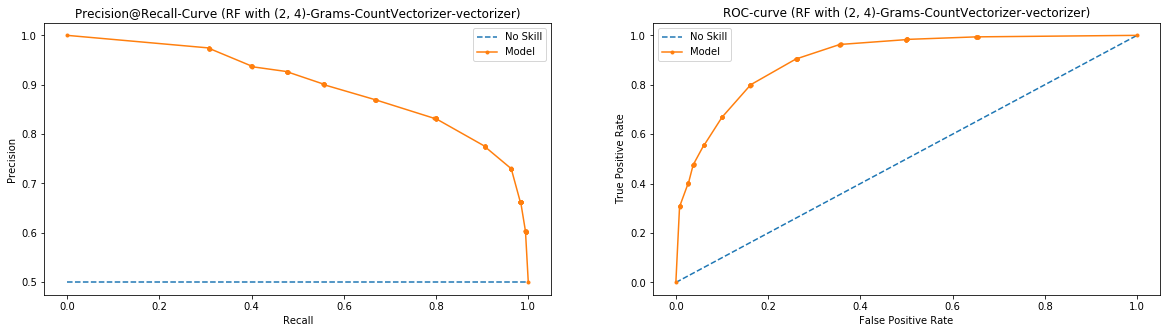

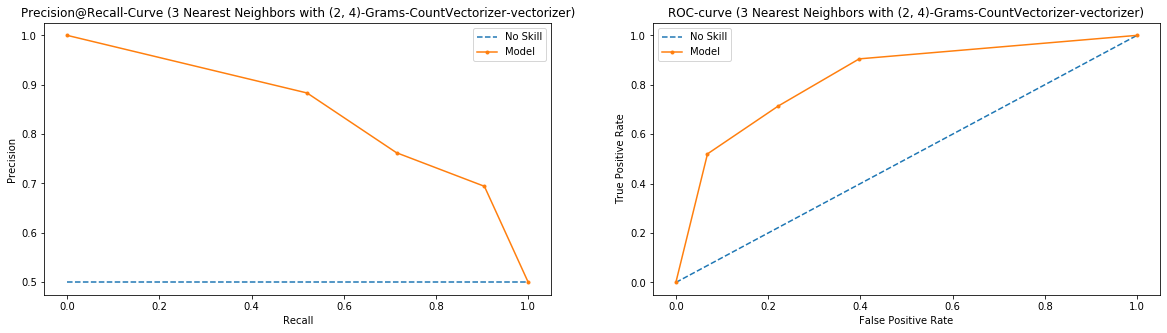

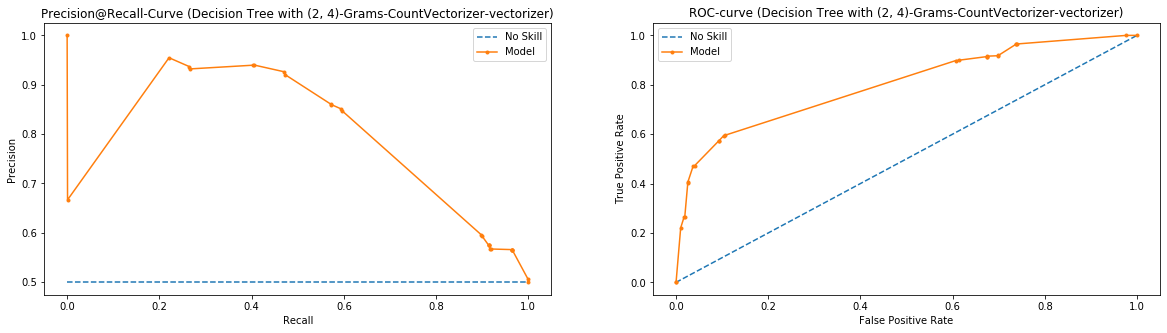

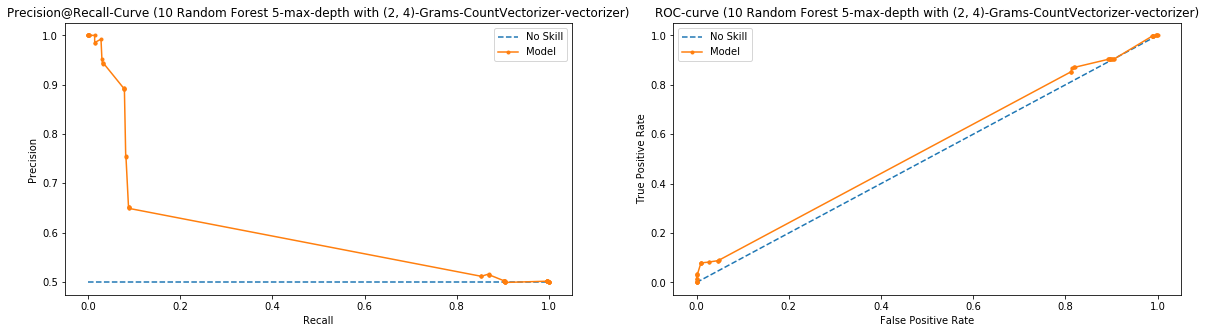

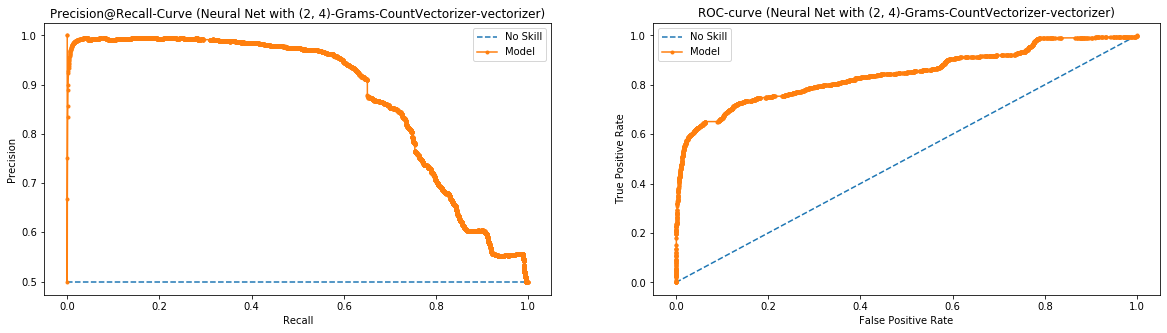

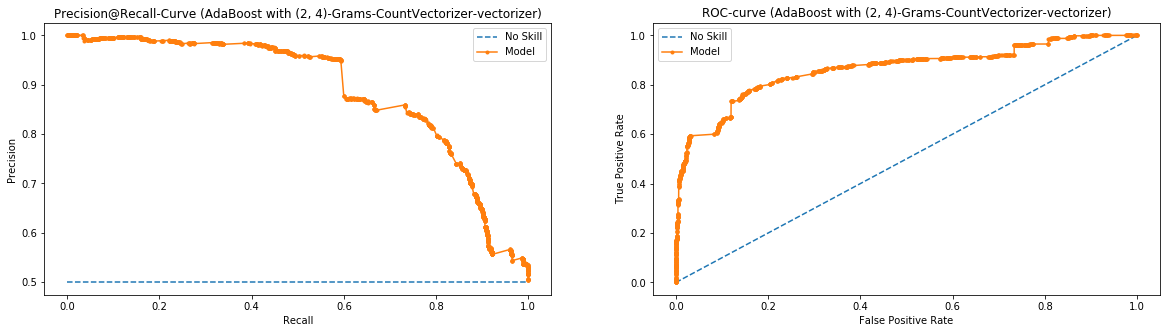

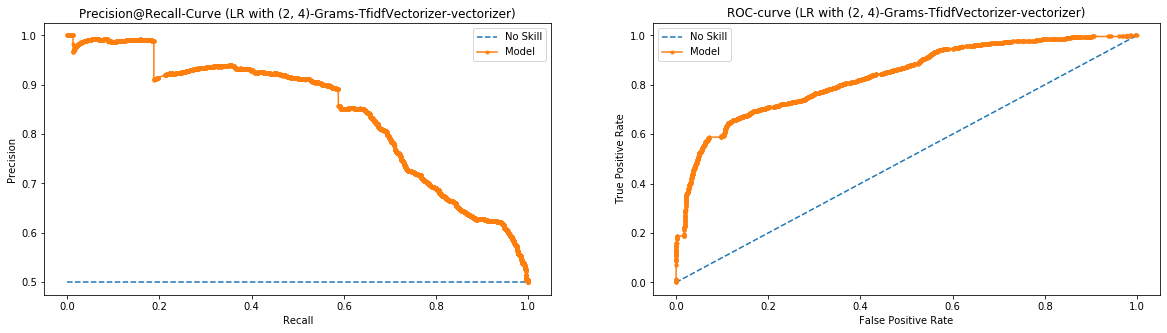

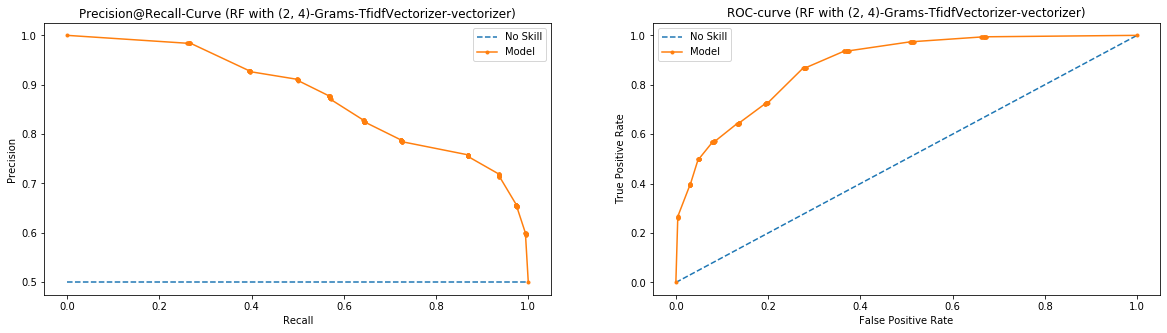

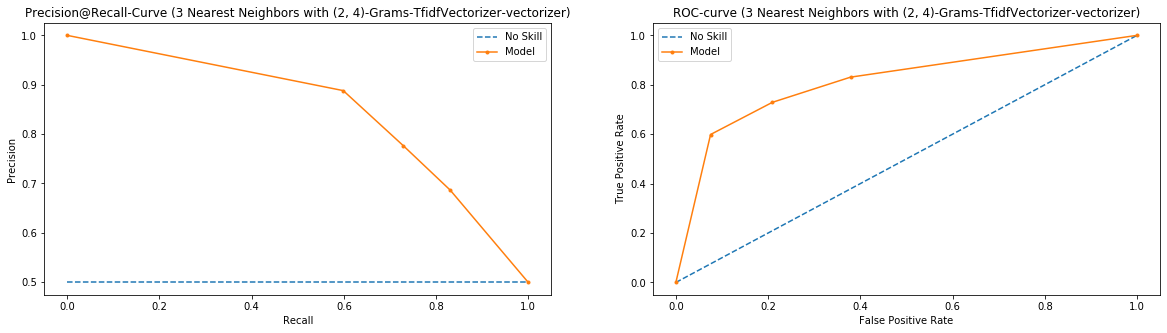

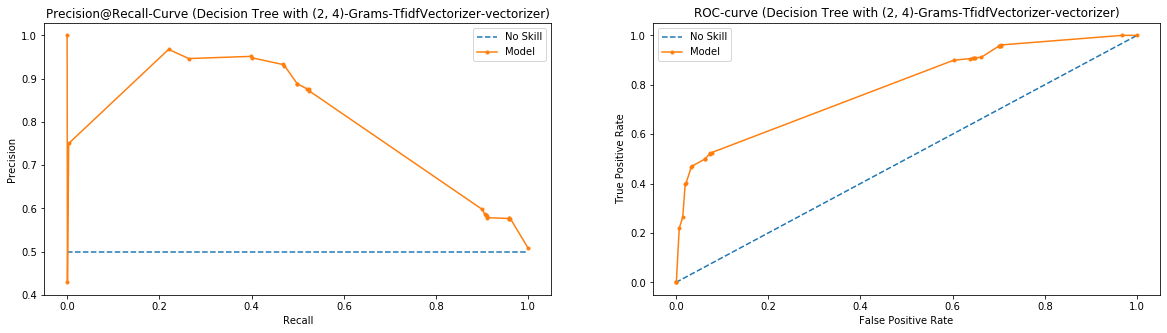

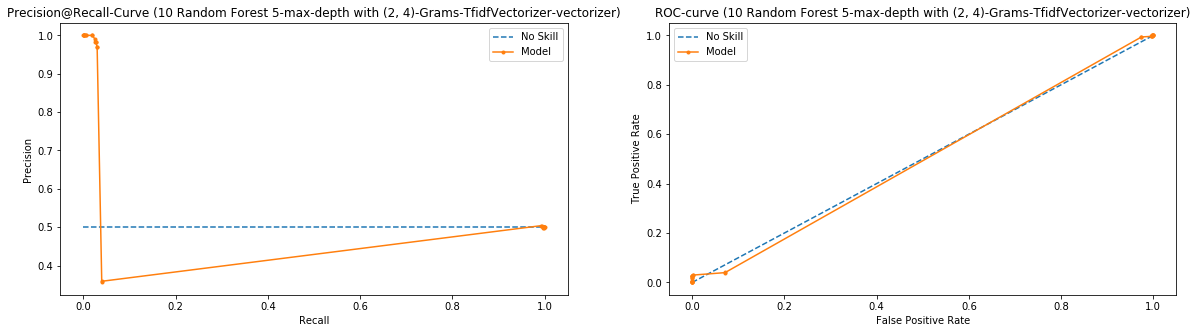

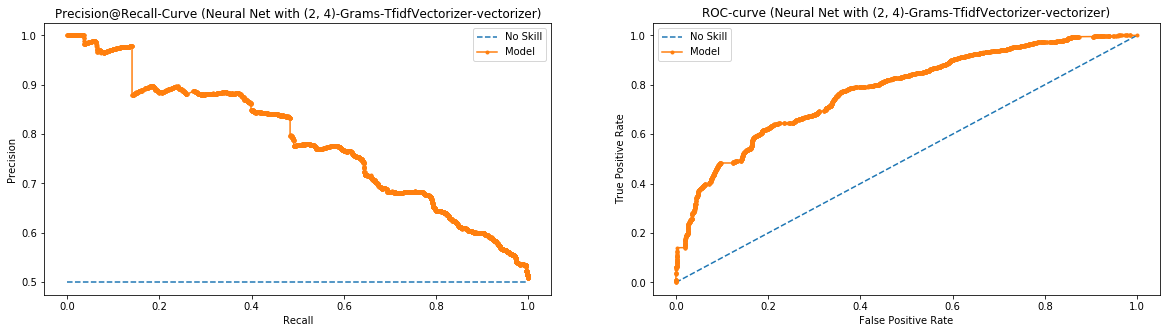

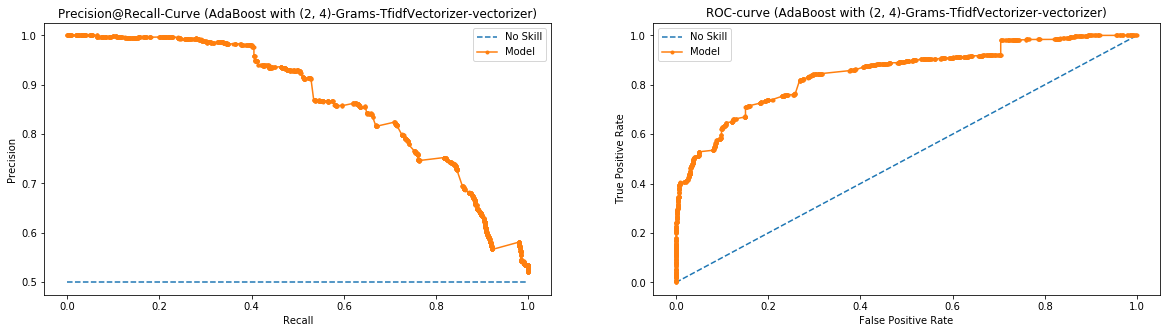

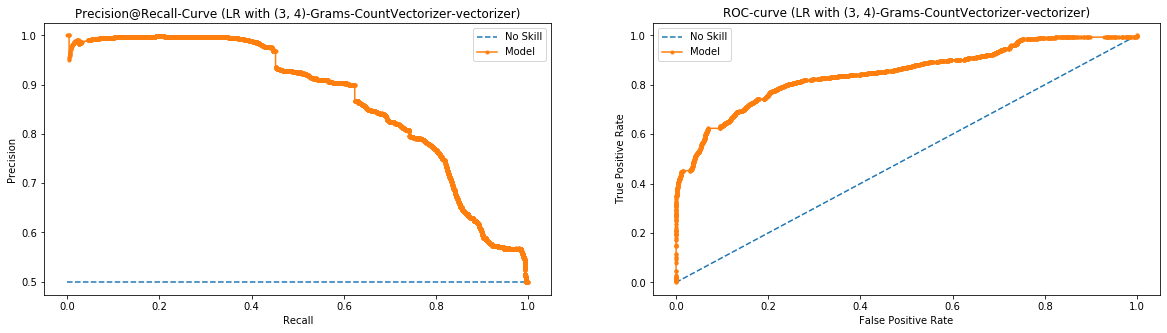

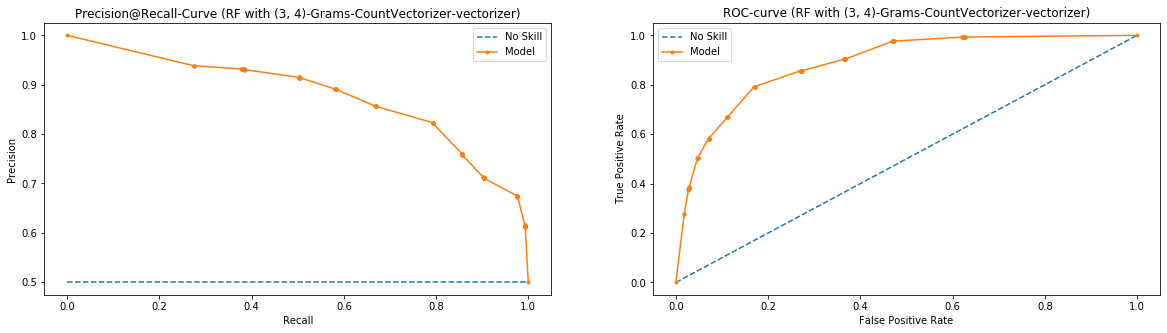

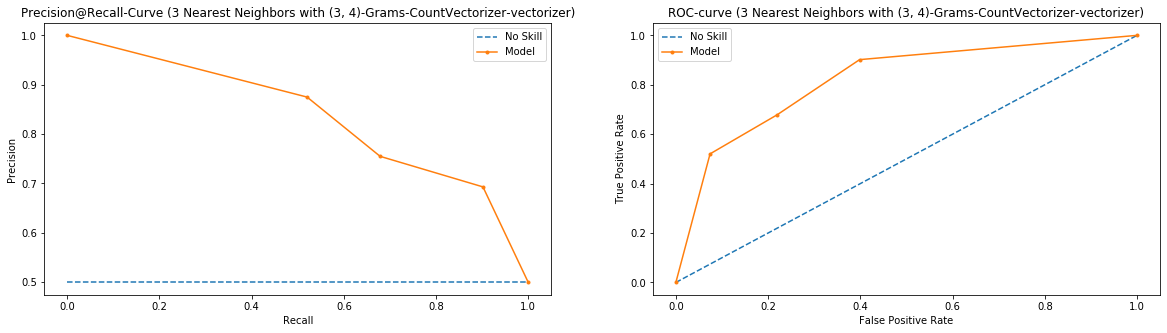

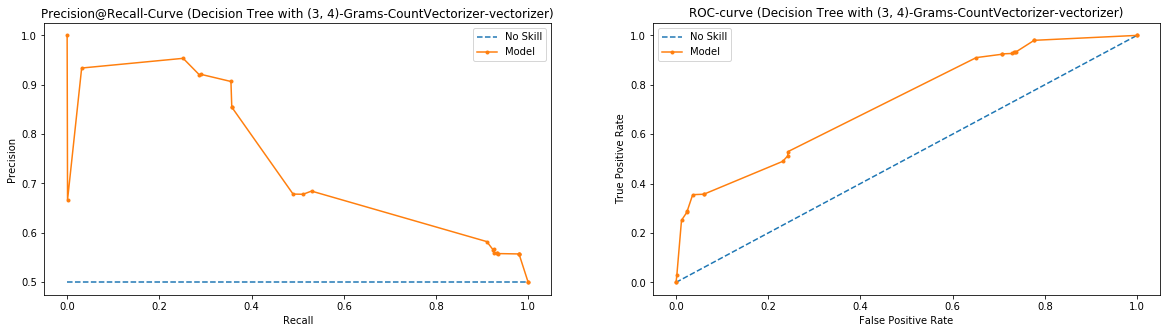

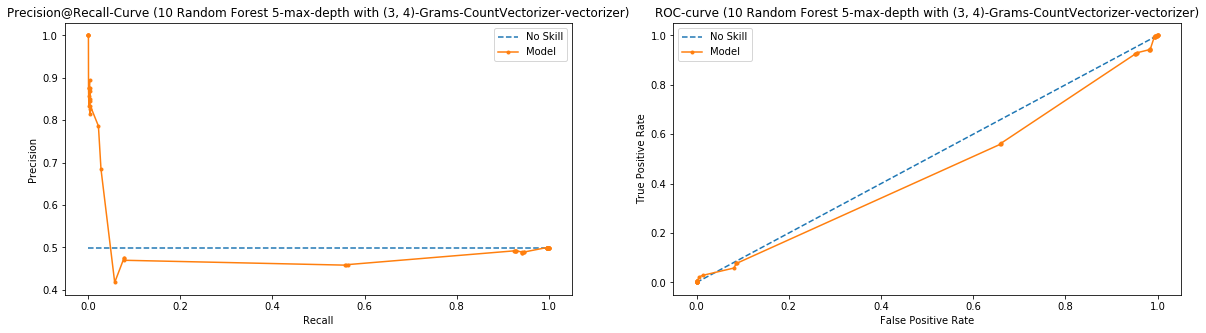

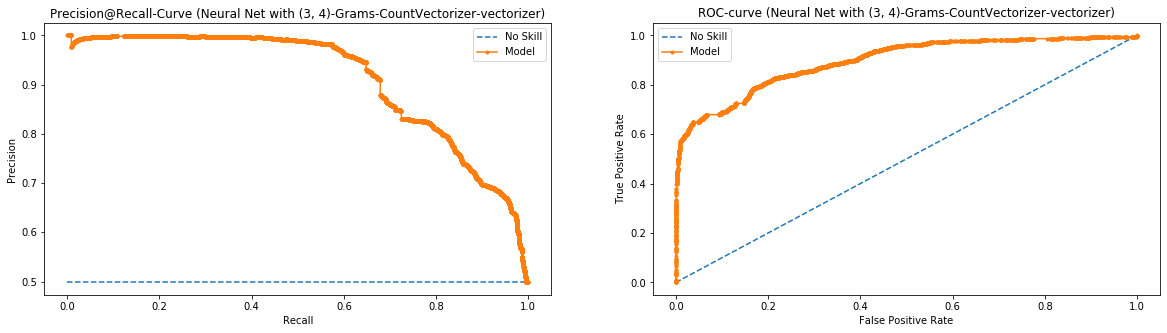

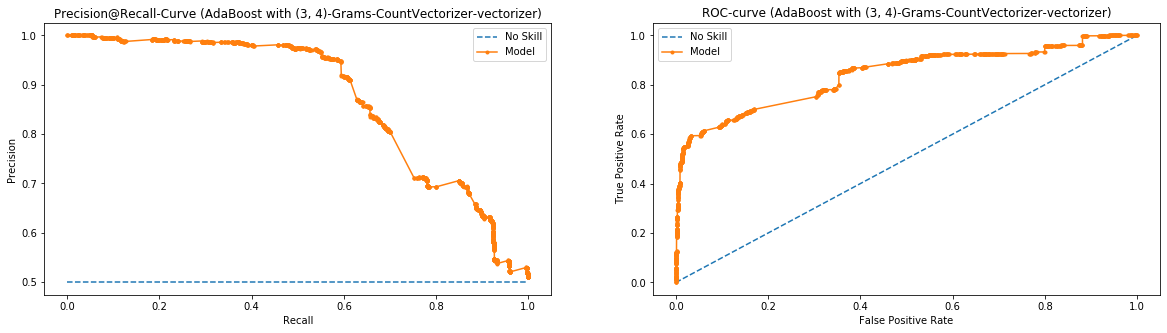

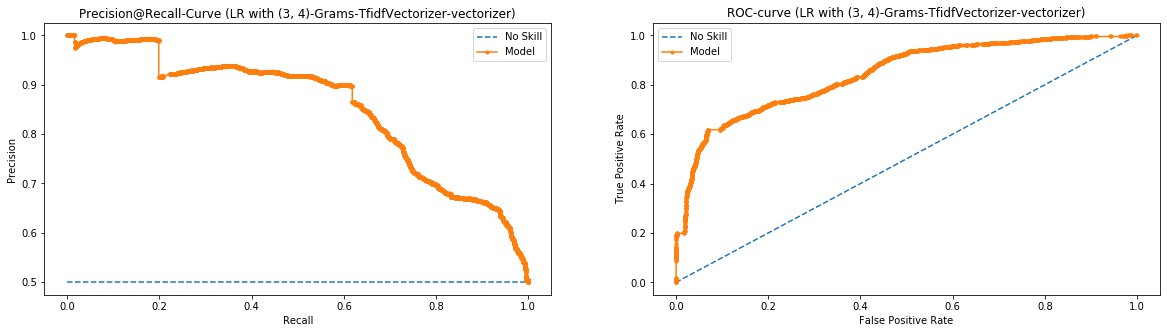

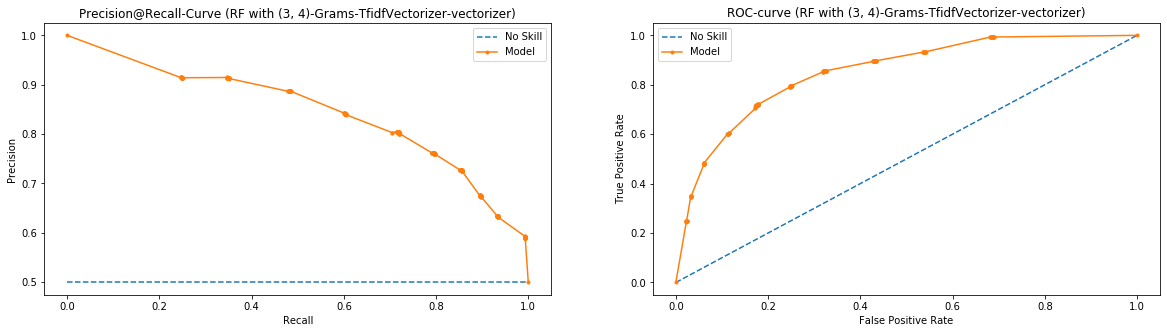

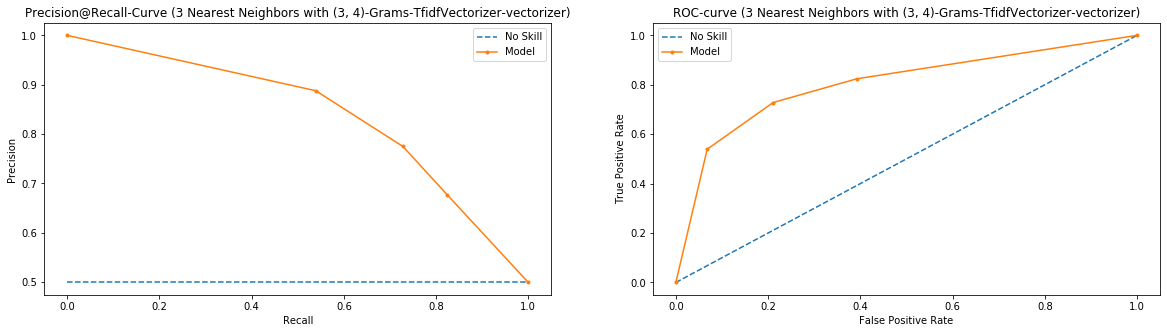

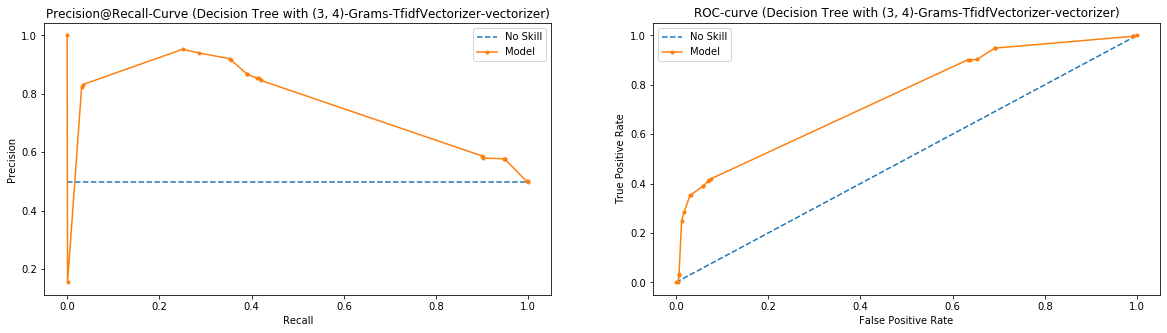

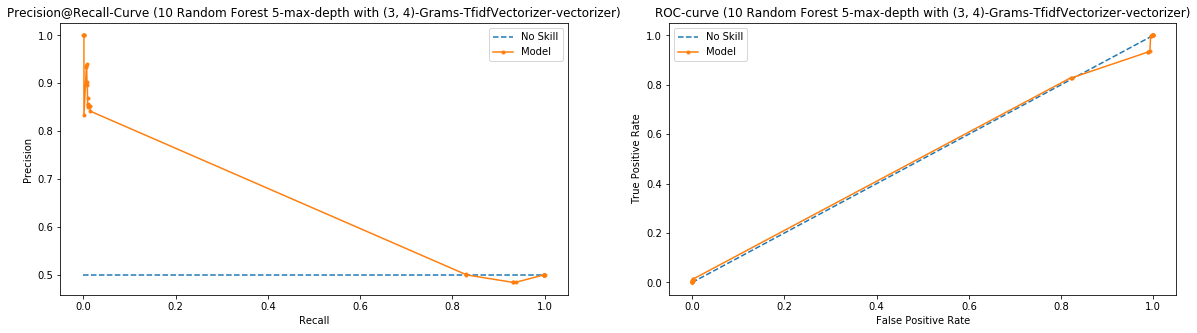

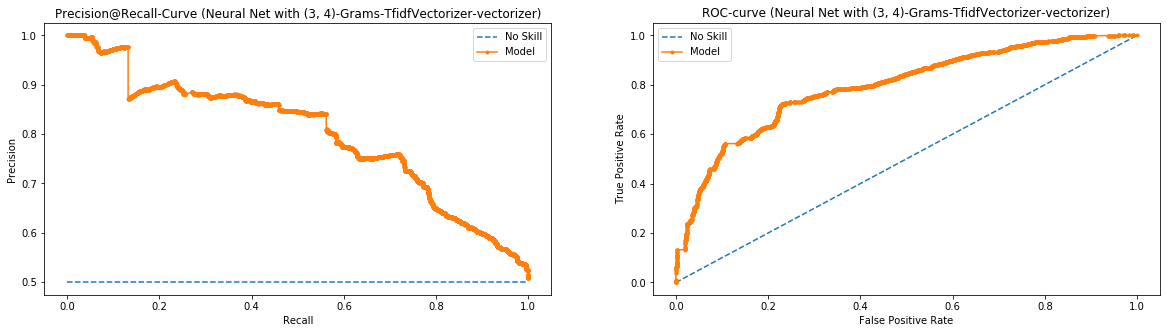

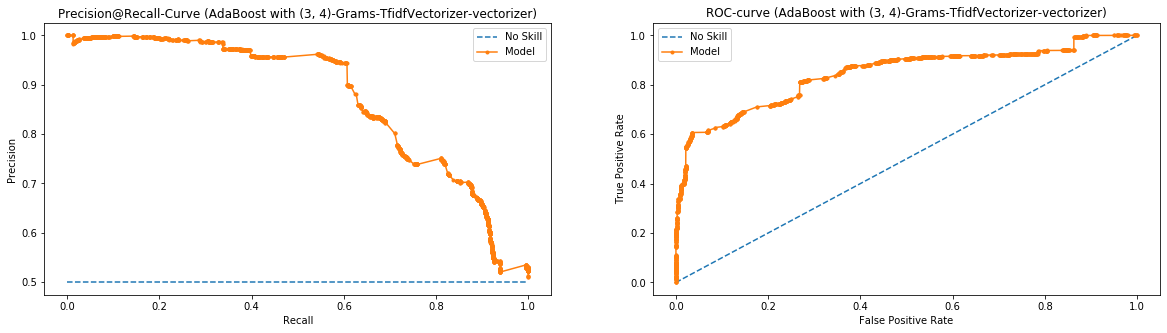

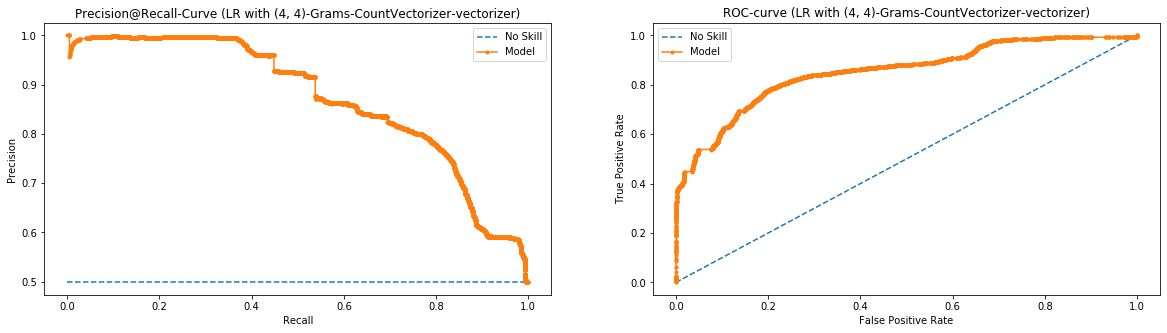

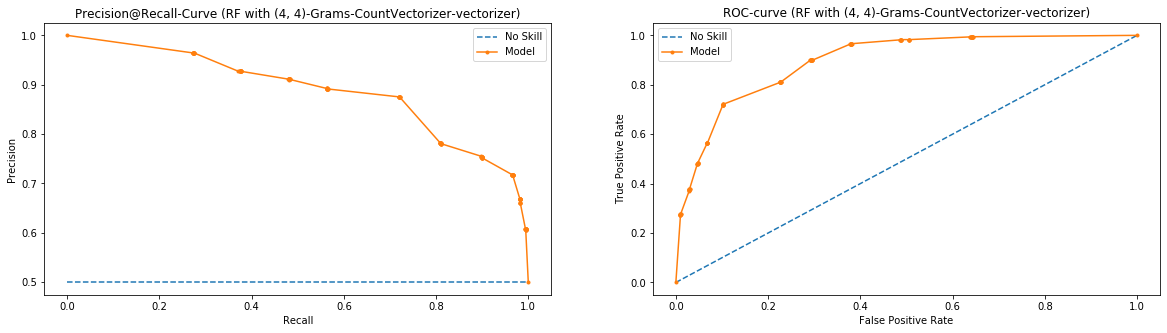

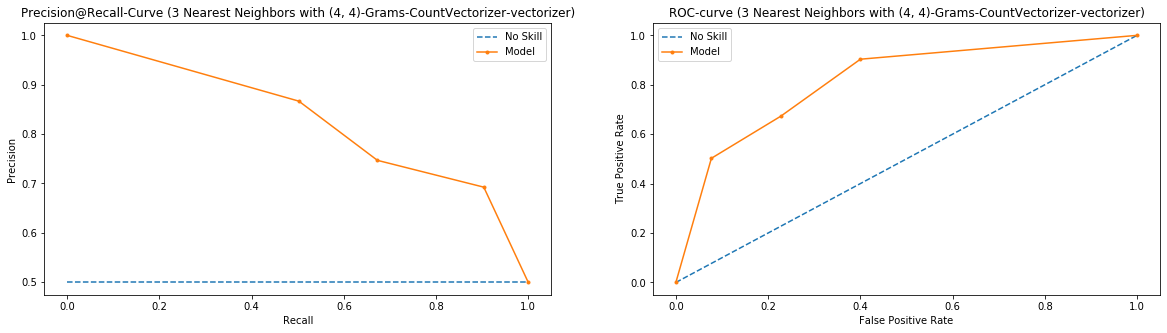

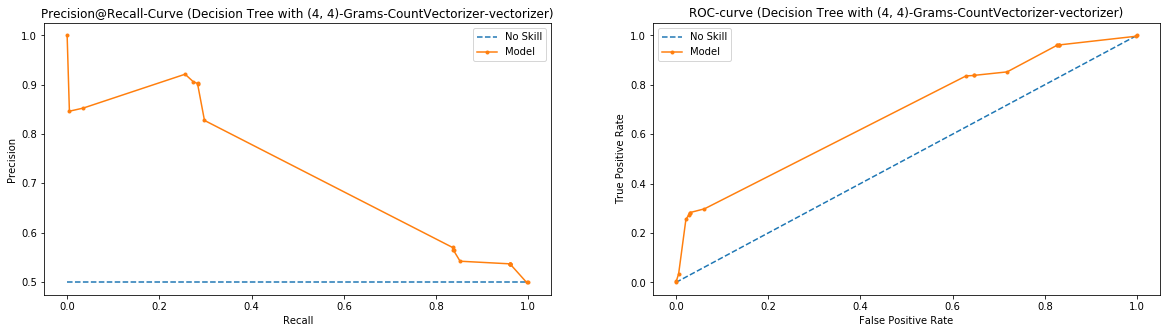

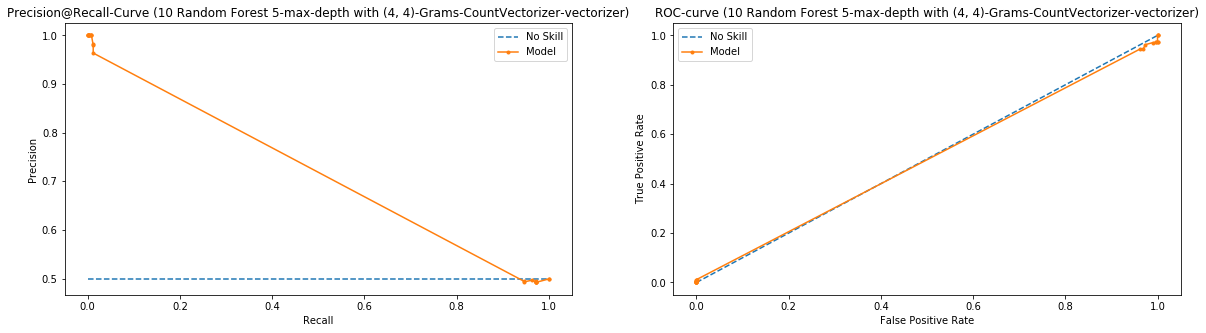

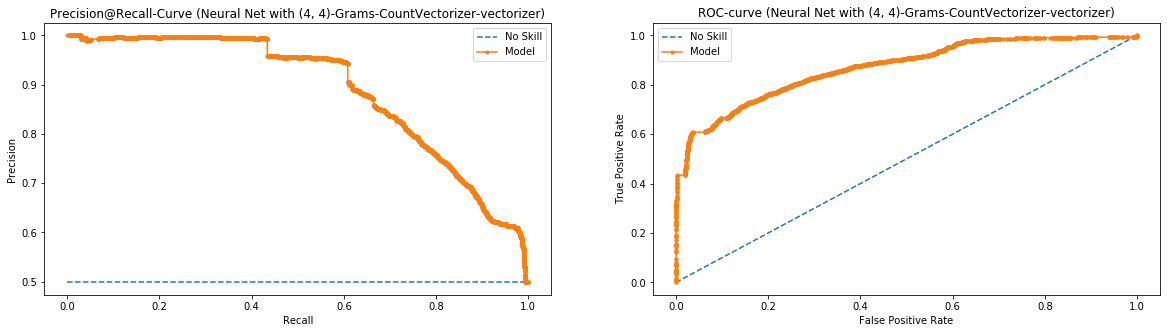

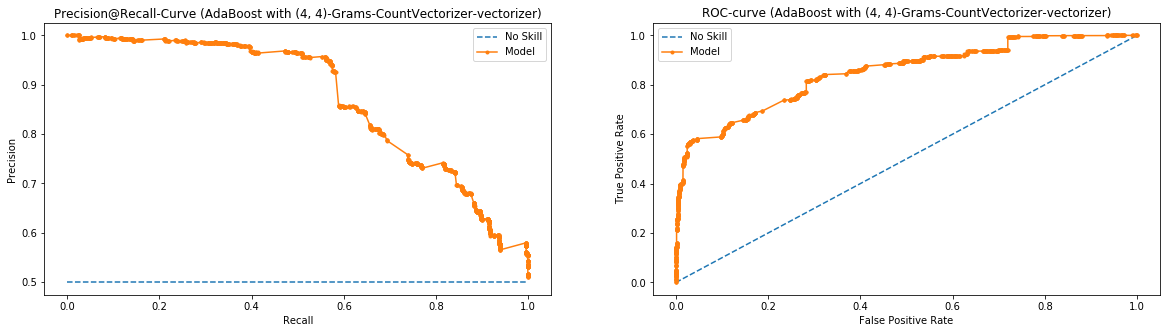

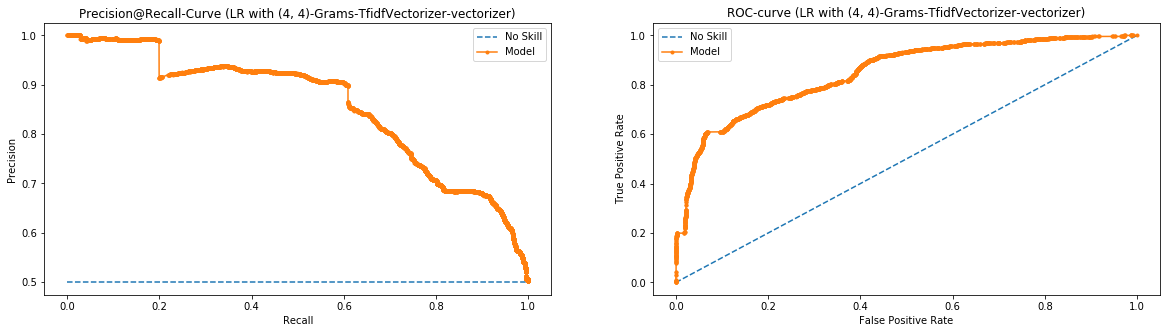

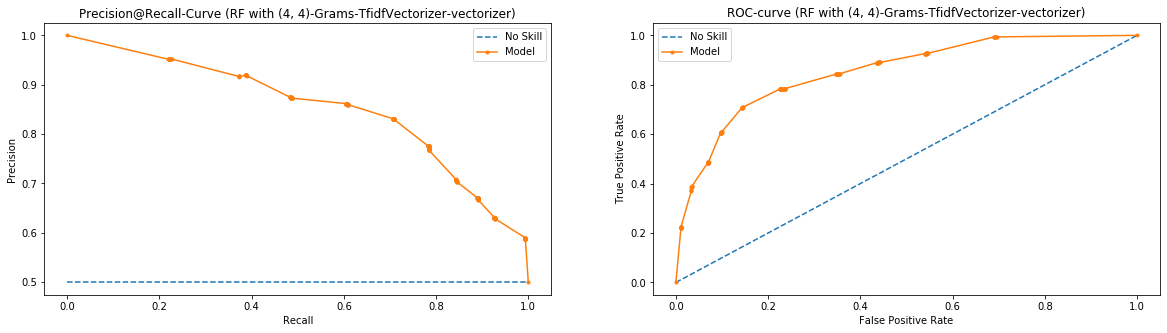

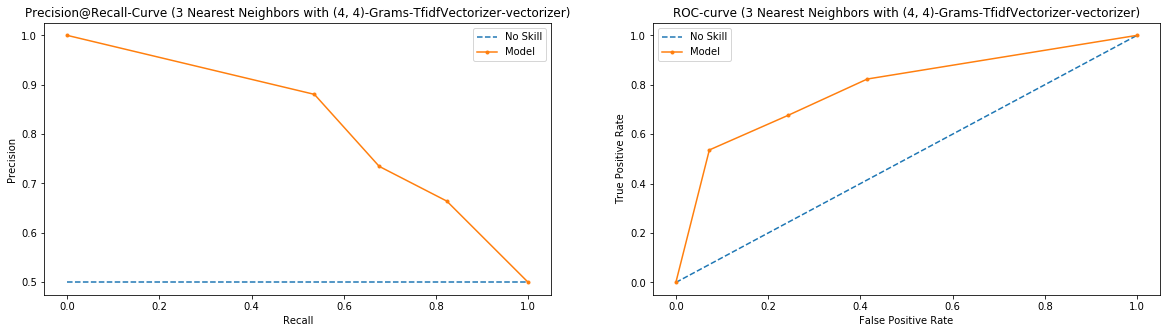

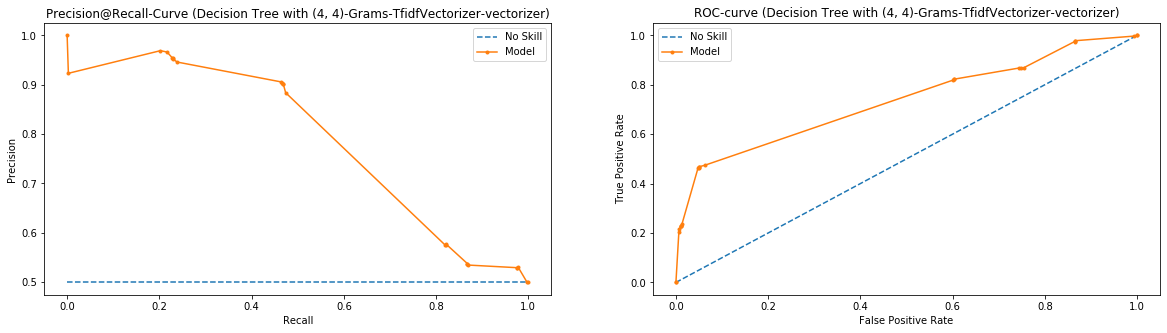

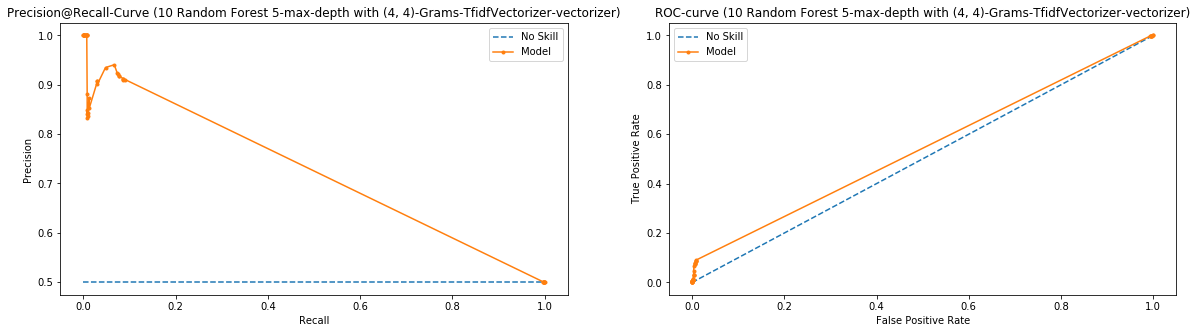

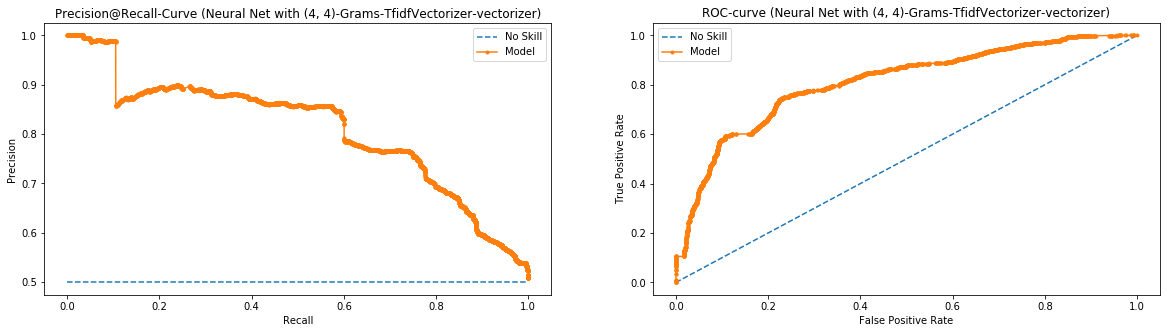

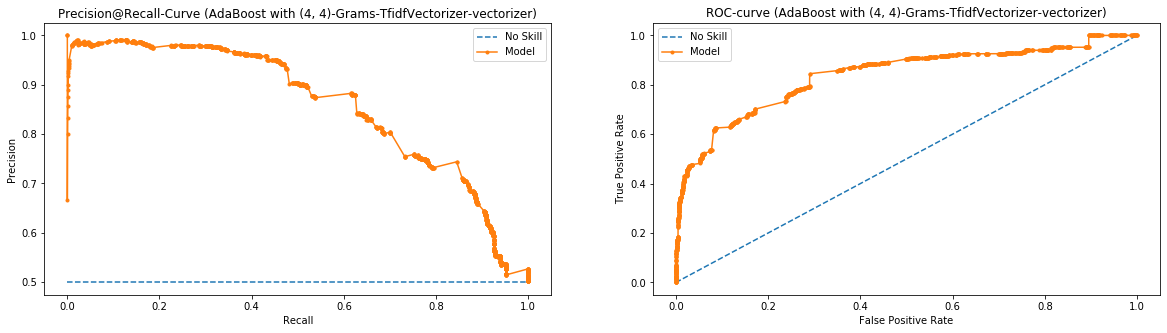

In [15]:
max_score = -1
winning_model = "none"
scoreboard_dict_list = []
metrics_dict_list = []

for ngram, ngram_name in ngrams_dict_list:
    for vectorizer, vectorizer_name in vectorizers_and_names_list:
        # create a count/tfidf vectorizer object 
        count_vect = vectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=ngram)
        count_vect.fit(train_x)
        
        # transform the training and test data using count vectorizer object
        xtrain_count =  count_vect.transform(train_x)
        xtest_count =  count_vect.transform(test_x)

        # build model
        for model_func, model_name in models_and_names_list:
            description = model_name + " with "  + ngram_name + "-" + vectorizer_name + "-vectorizer"
            print("model: " + description)
            print("\n")
            # run curves functionFleece
            metrics = train_test_model(model_func, description, xtrain_count, train_y, xtest_count, test_y)
            score = metrics['precision']
            if score > max_score:
                max_score = score
                winning_model = description
            score_dict = {}
            score_dict['model'] = description
            score_dict['score'] = score
            scoreboard_dict_list.append(score_dict)
            metrics_dict_list.append(metrics)
        
print("############################")
print("and the winner is........")
print(winning_model)
print("!!!!!!!!!!!!")
print("############################")




In [16]:
scoreboard_dict_list

[{'model': 'LR with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.7138221933809215},
 {'model': 'RF with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.7942951179374658},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.735080058224163},
 {'model': 'Decision Tree with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.6276448942042319},
 {'model': '10 Random Forest 5-max-depth with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.6583333333333333},
 {'model': 'Neural Net with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.6668060200668896},
 {'model': 'AdaBoost with (1, 1)-Grams-CountVectorizer-vectorizer',
  'score': 0.7267428304966193},
 {'model': 'LR with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.6635364635364636},
 {'model': 'RF with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.8210146793716199},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-TfidfVectorizer-vectorizer',
  'score

In [17]:
top_ten = sorted(scoreboard_dict_list, key=lambda d: d['score'], reverse=True)[0:10]

In [20]:
print("Top 10 models: (by precision metric)")



top_ten

Top 10 models: (by precision metric)


[{'model': 'LR with (4, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.984181568088033},
 {'model': 'RF with (1, 3)-Grams-CountVectorizer-vectorizer',
  'score': 0.9830388692579505},
 {'model': 'RF with (3, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9815733522324592},
 {'model': 'RF with (2, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9812680115273775},
 {'model': 'RF with (3, 3)-Grams-CountVectorizer-vectorizer',
  'score': 0.9788583509513742},
 {'model': 'LR with (2, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9783050847457627},
 {'model': 'RF with (1, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9762076423936553},
 {'model': 'Decision Tree with (1, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9757785467128027},
 {'model': 'RF with (4, 4)-Grams-CountVectorizer-vectorizer',
  'score': 0.9745699326851159},
 {'model': 'RF with (1, 3)-Grams-TfidfVectorizer-vectorizer',
  'score': 0.9739069111424542}]

In [18]:
metrics_dict_list

[{'model': 'LR with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.7138221933809215,
  'recall': 0.7372654155495979,
  'ROC_auc': 0.7821883004830514,
  'acc': 0.7212803925942449,
  'lr_PR_f1': 0.7253544345532477,
  'lr_PR_auc': 0.8076345480908542,
  'ns_auc': 0.5,
  'lr_auc': 0.7821883004830514},
 {'model': 'RF with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.7942951179374658,
  'recall': 0.6470062555853441,
  'ROC_auc': 0.8491219689867862,
  'acc': 0.7401293776488959,
  'lr_PR_f1': 0.7131248460970204,
  'lr_PR_auc': 0.854696557886442,
  'ns_auc': 0.5,
  'lr_auc': 0.8491219689867862},
 {'model': '3 Nearest Neighbors with (1, 1)-Grams-CountVectorizer-vectorizer',
  'precision': 0.735080058224163,
  'recall': 0.6769436997319035,
  'ROC_auc': 0.7905591514058646,
  'acc': 0.7169306268124024,
  'lr_PR_f1': 0.7048150732728542,
  'lr_PR_auc': 0.8129933855161764,
  'ns_auc': 0.5,
  'lr_auc': 0.7905591514058646},
 {'model': 'Decision Tree with (1, 1)-Grams-CountVector

# the end (:

In [36]:
import csv
with open(os.path.join(cuckoo_reports_dir_Path, "models_metrics.csv"), 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, metrics_dict_list[0].keys())
    w.writeheader()
    for metrics_dict in metrics_dict_list:
        w.writerow(metrics_dict)
